# Load Model and verify that it's bias free

In [90]:
import os
import numpy as np
import torch
import util
import matplotlib.pyplot as plt
from data import fr
from torch.autograd.gradcheck import zero_gradients
%matplotlib inline
from utils_project import *
from data.data import gen_signal
# three outputs from this function: signal [num_samples, 2, signal_dim]; frequency (float)[num_samples, num_freq];
# num_freq:int [num_samples] 
from data.noise import noise_torch
from data import fr
# find nearest
import matplotlib.backends.backend_pdf

fr_path = 'checkpoint/model_snr_range_1_bias_no/fr/epoch_400.pth'
fc_path = 'checkpoint/model_snr_1_bias_no/fc/epoch_300.pth'
data_dir = 'test_dataset'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#load models
fr_module, _, _, _, _ = util.load(fr_path, 'fr', device)
fr_module.cpu()
fr_module.eval()
xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)

#load data
f = np.load(os.path.join(data_dir, 'f.npy'))
signal_0dB = np.load(os.path.join(data_dir, '0.0dB.npy'))
signal_10dB = np.load(os.path.join(data_dir, '10.0dB.npy'))
signal_50dB = np.load(os.path.join(data_dir, '50.0dB.npy'))
nfreq = nfreq = np.sum(f >= -0.5, axis=1)

In [91]:
inp = torch.as_tensor(signal_10dB[1]).unsqueeze(dim=0)
jacobian, inputs, outputs = compute_jacobian_and_bias(inp, fr_module)
bias = compute_bias(jacobian, inputs, outputs)

In [92]:
fft_filter = jacobian[0] - 1j * jacobian[1]
bias = bias.reshape(-1)

In [93]:
fft_filter.shape

(50, 1000)

In [82]:
f[1]

array([ -0.49367598,  -0.46647468,  -0.43446055,  -0.4144162 ,
        -0.39220992,  -0.34944528,  -0.29635686,  -0.26388544,
        -0.23259251, -10.        ], dtype=float32)

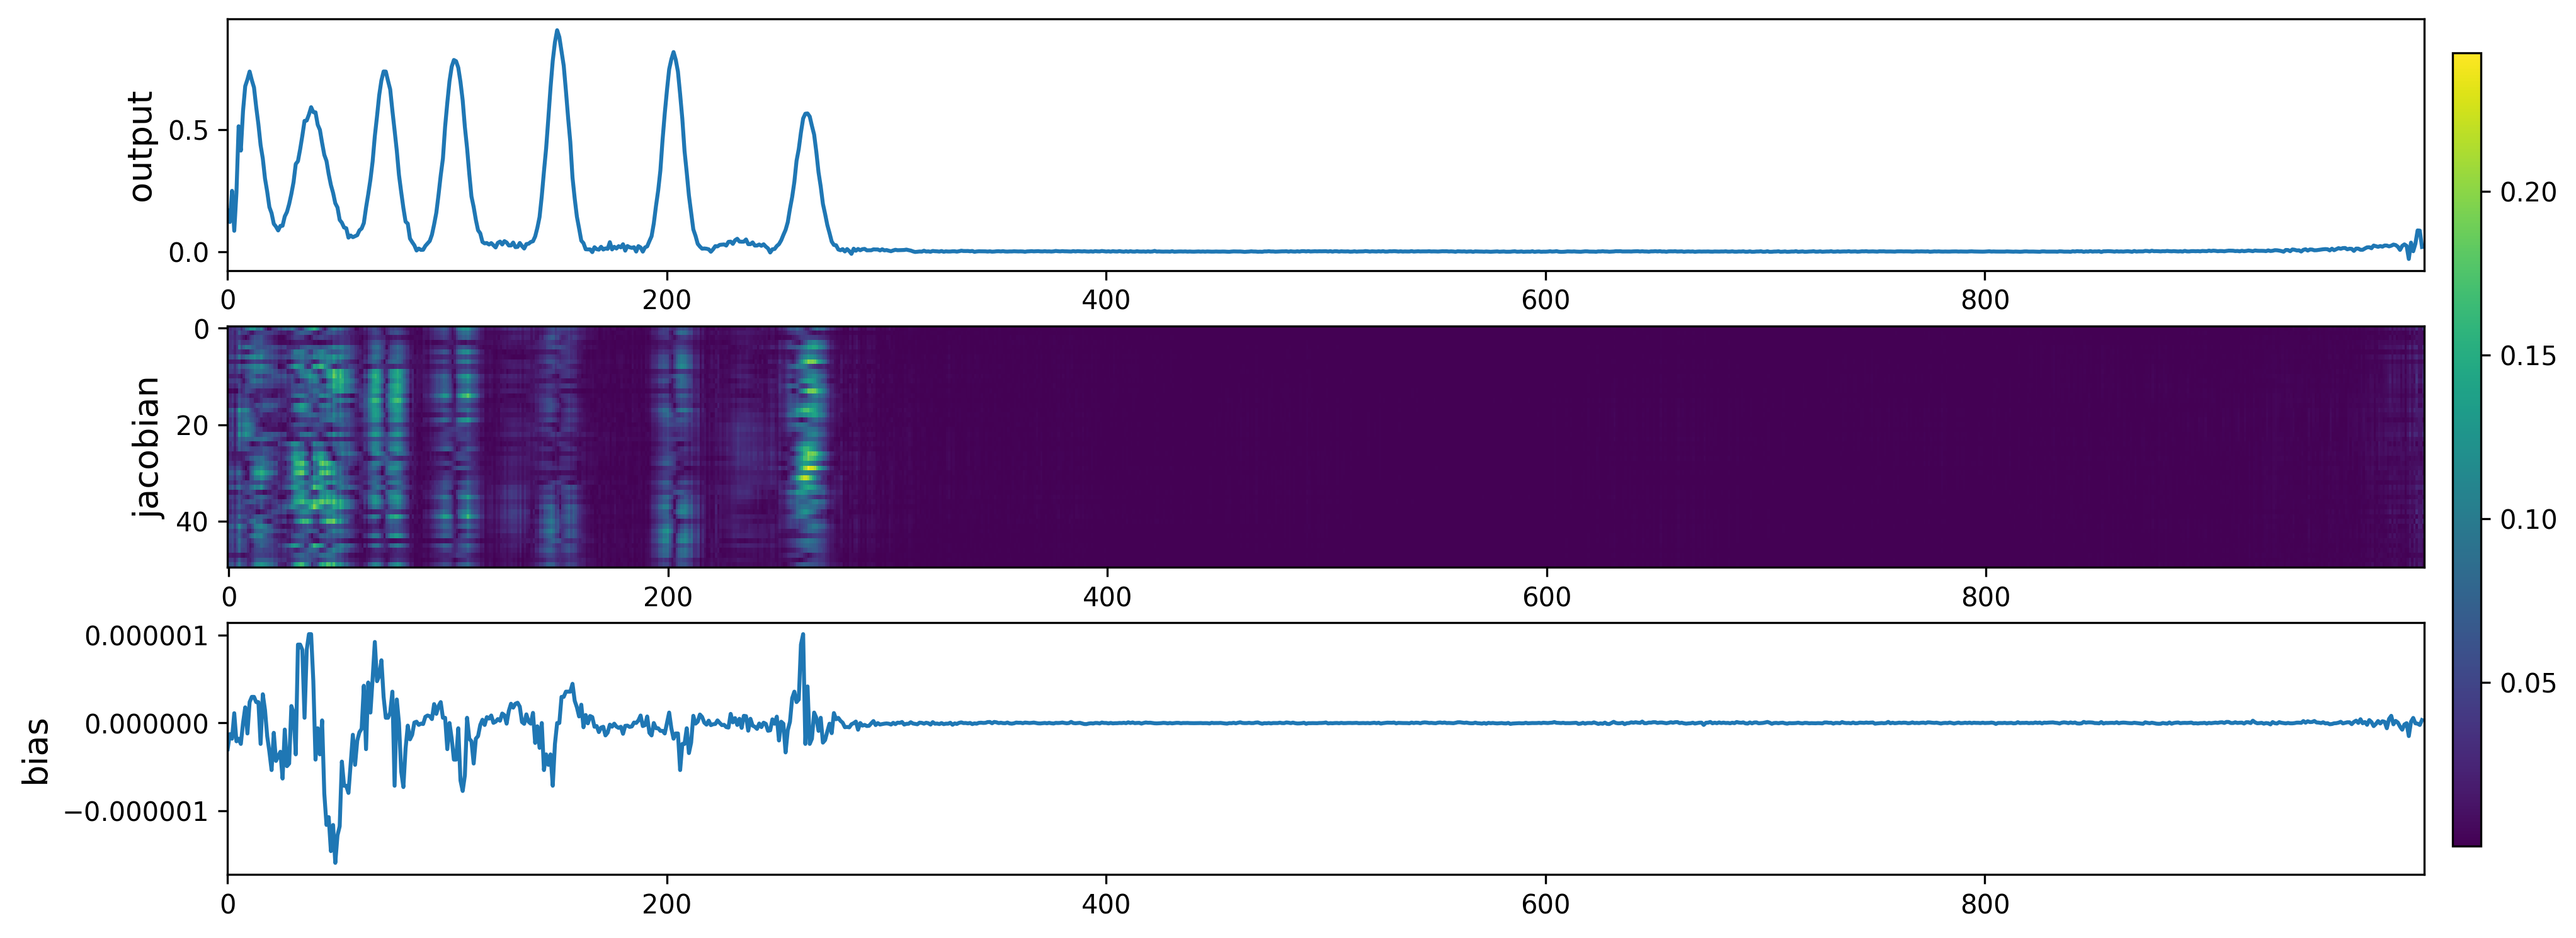

In [94]:
fig, ax = plt.subplots(3, 1, figsize=(15, 6), dpi=300)

ax[0].plot(xgrid, outputs[0])
ax[0].set_xticks(np.arange(-0.5, 0.5, 0.2))
ax[0].set_xticklabels(np.arange(0, 1000, 200))
ax[0].set_xlim(-0.5, 0.5)
ax[0].set_ylabel('output', fontsize=13)

im = ax[1].imshow(np.abs(fft_filter))
ax[1].set_aspect(2.2)
ax[1].set_ylabel('jacobian', fontsize=13)

ax[2].plot(xgrid, bias)
ax[2].set_xticks(np.arange(-0.5, 0.5, 0.2))
ax[2].set_xticklabels(np.arange(0, 1000, 200))
ax[2].set_xlim(-0.5, 0.5)
ax[2].set_ylabel('bias', fontsize=13)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
# plt.tight_layout()
plt.savefig('jacobian.png', dpi=300)
plt.show()

# Analysis

In [130]:
# hyper parameter setting
num_samples=10
signal_dim=50
min_sep=1.
snr=10
#fixed_freq = [0.1,0.15, 0.2, 0.25, 0.3, 0.35, 0.4] # set None for  random frequency
fixed_freq = [0.4, 0.38]
num_freq=len(fixed_freq)

In [131]:
clean_signals, signal_frs, signal_num_freqs = gen_signal(num_samples=num_samples, 
                                                         signal_dim=signal_dim, 
                                                         num_freq=num_freq, min_sep=min_sep,
                                                        fixed_freq=fixed_freq)
noisy_signals = noise_torch(torch.as_tensor(clean_signals), snr, 'gaussian')


## Doing FFT on noisy/clean  signal

In [132]:
idx = 1

In [133]:
clean_signal, signal_fr, signal_num_freq = clean_signals[idx], signal_frs[idx], signal_num_freqs[idx]
noisy_signal = noisy_signals[idx].cpu().numpy()
clean_signal_t = clean_signal[0] + clean_signal[1] * 1j 
clean_signal_fft = np.fft.fft(clean_signal_t, n=1000)
clean_signal_fft = np.fft.fftshift(clean_signal_fft)
noisy_signal_t = noisy_signal[0] + 1j * noisy_signal[1]
noisy_signal_fft = np.fft.fft(noisy_signal_t, n=1000)
noisy_signal_fft = np.fft.fftshift(noisy_signal_fft)
noisy_signal = torch.as_tensor(noisy_signal).unsqueeze(dim=0)
jacobian, inputs, outputs = compute_jacobian_and_bias(noisy_signal, fr_module)


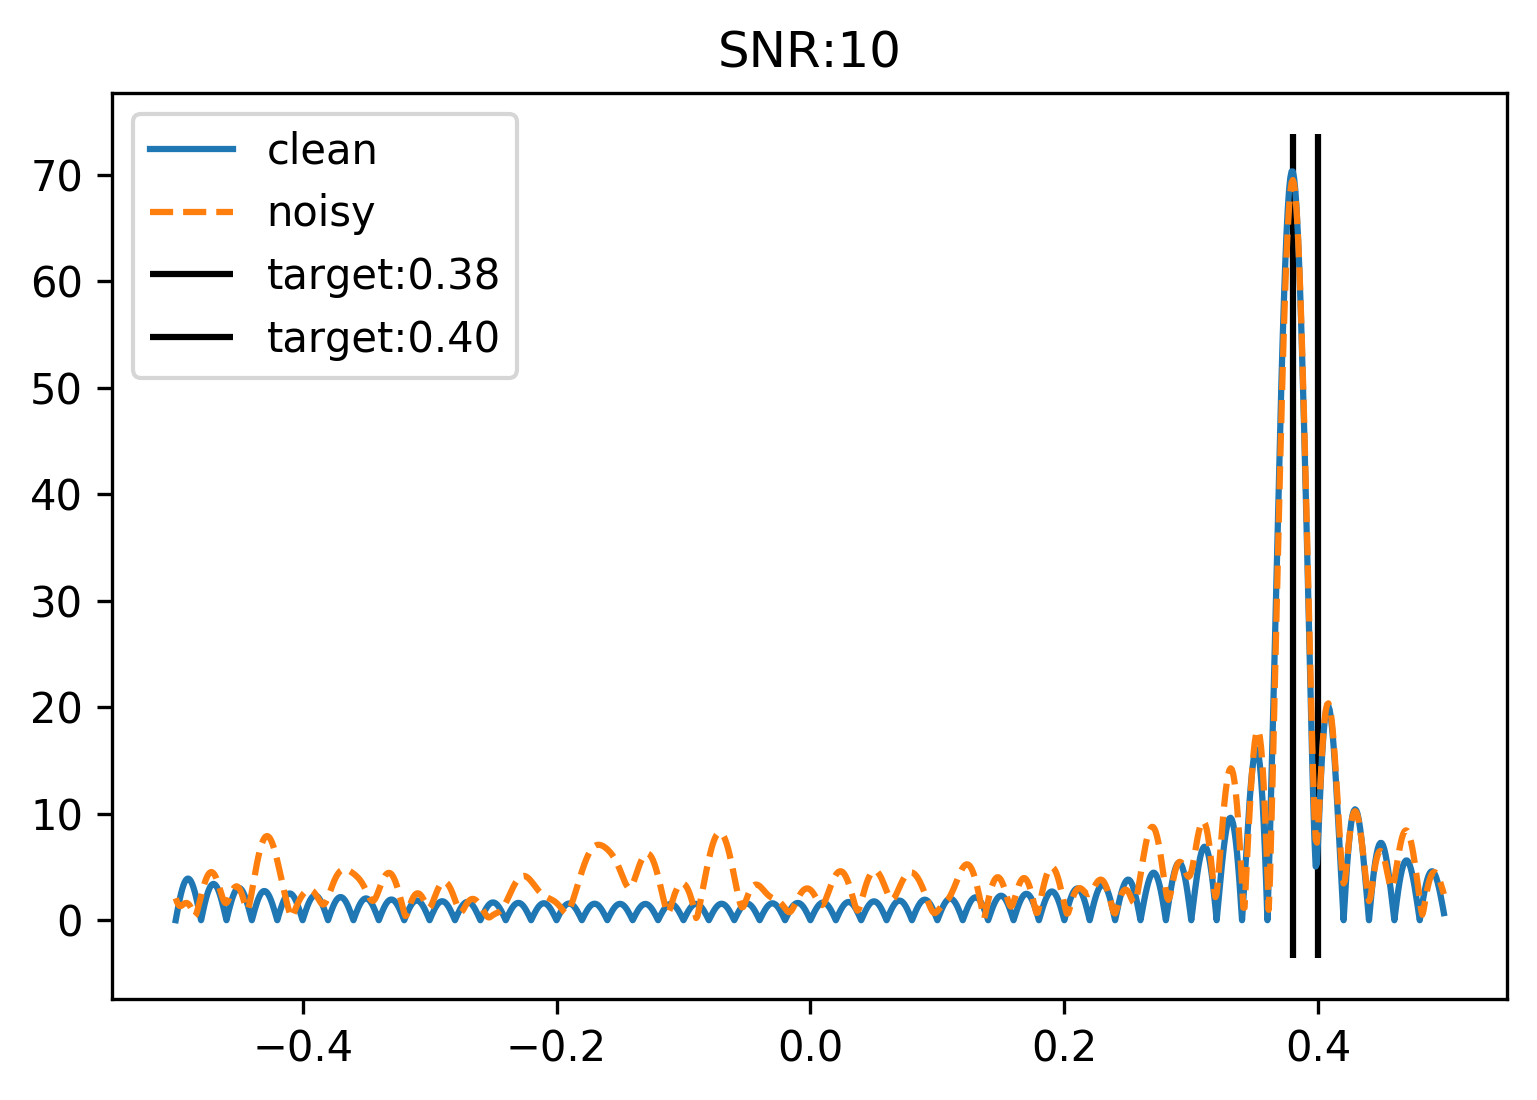

In [134]:
fig, ax = plt.subplots(dpi=300)
xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)
ax.plot(xgrid, np.abs(clean_signal_fft),label='clean')
ax.plot(xgrid, np.abs(noisy_signal_fft),'--', label='noisy')
ylim = ax.get_ylim()
for i in range(signal_fr.shape[0]):
    ax.vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
ax.set_title('SNR:{}'.format(snr))
ax.legend()

(-0.5, 0.5)

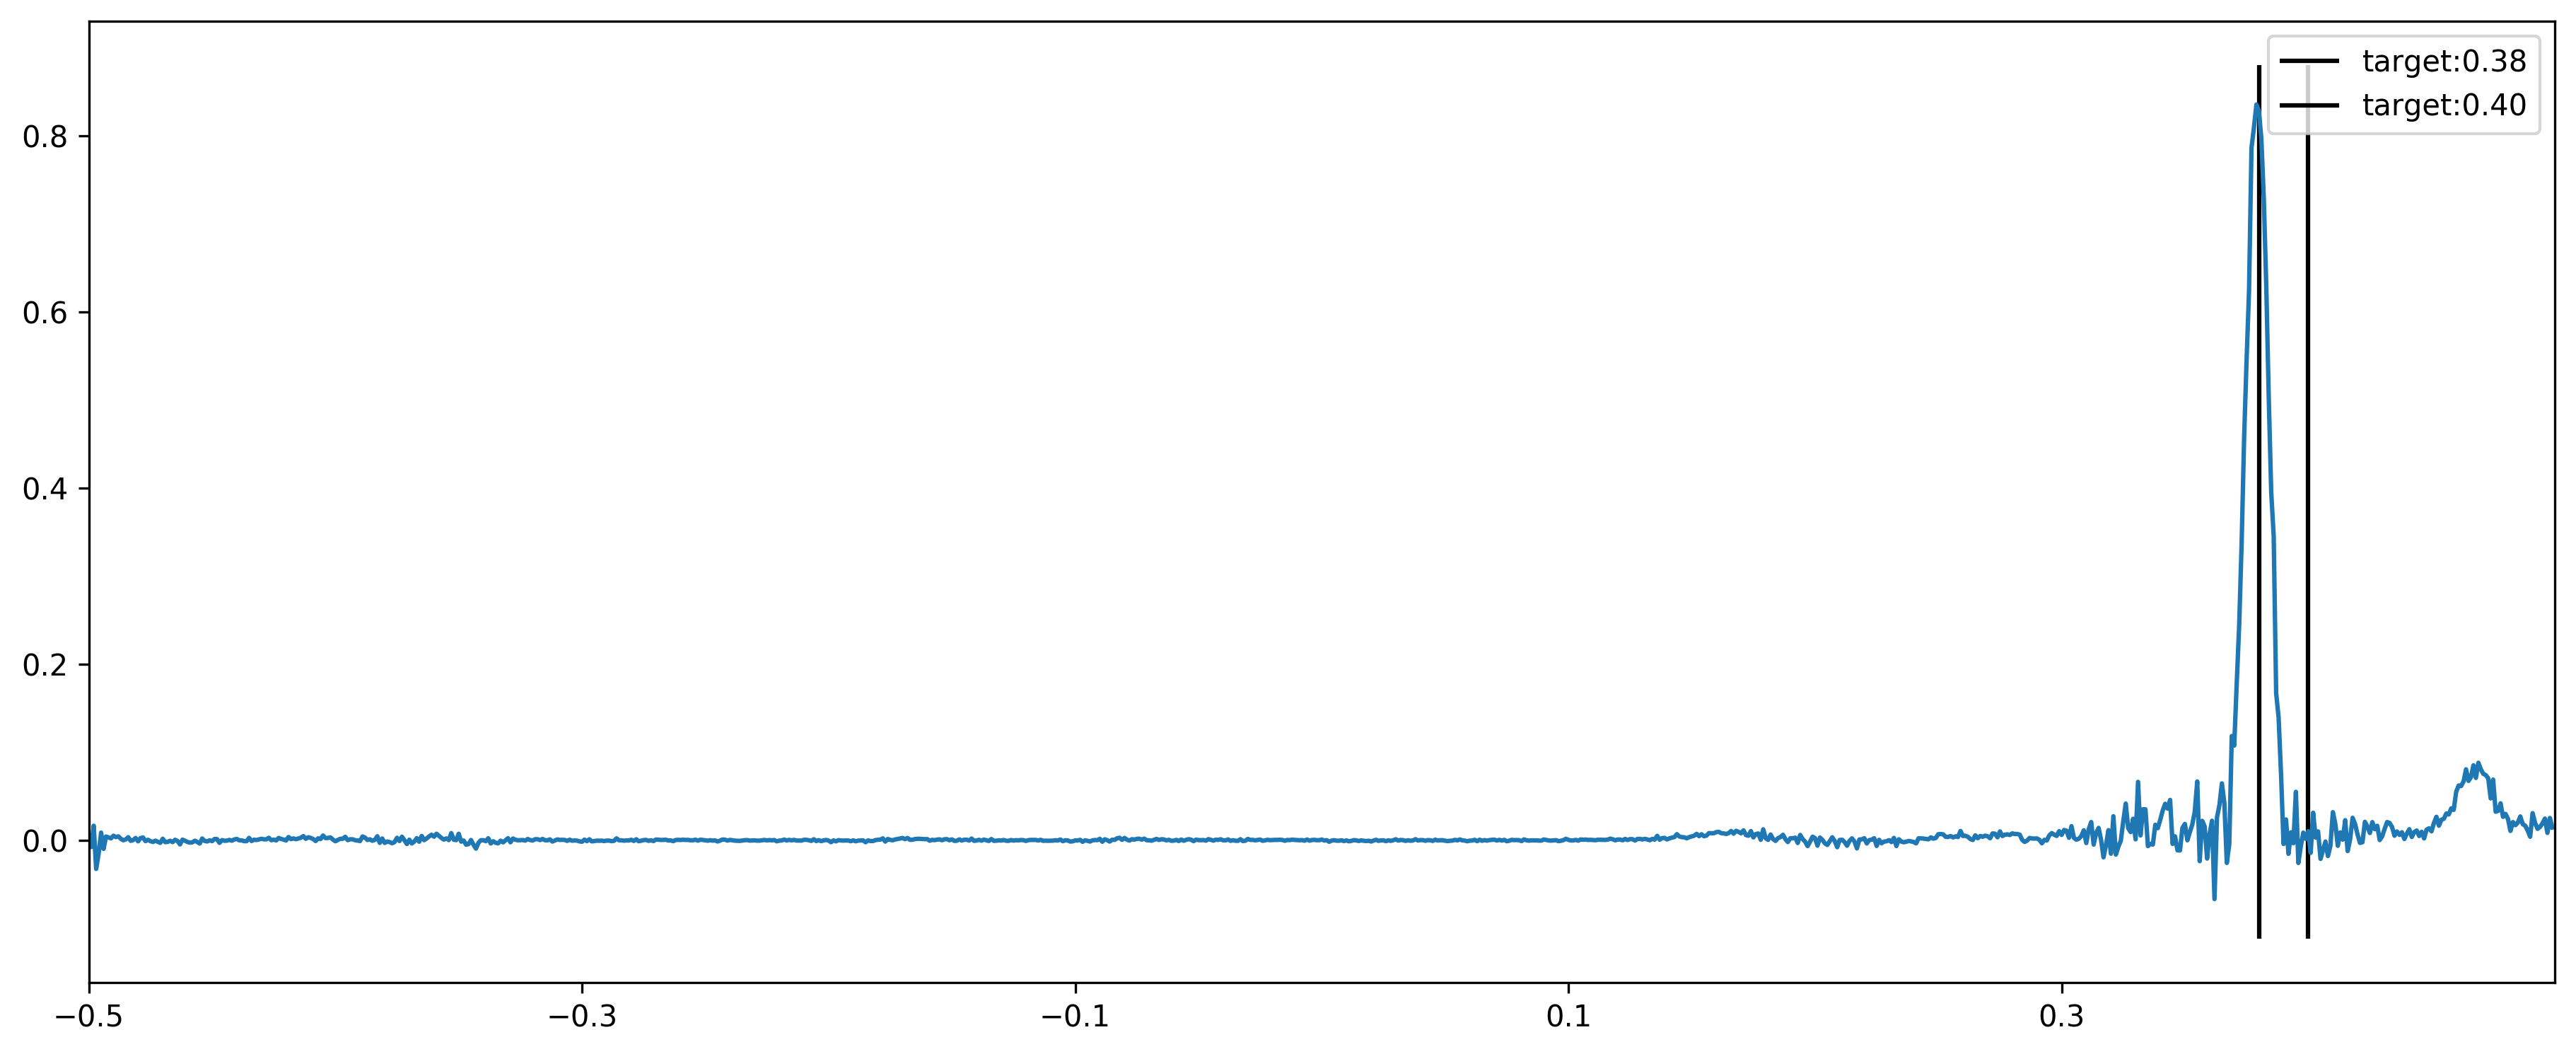

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), dpi=300)
xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)
ax.plot(xgrid, outputs[0])
ax.set_xticks(np.arange(-0.5, 0.5, 0.2))
ylim = ax.get_ylim()
for i in range(signal_fr.shape[0]):
    ax.vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
ax.legend()
ax.set_xlim(-0.5, 0.5)

In [106]:
fft_filter = jacobian[0] - 1j * jacobian[1]

## FFT  and Jacobian Row absolute value comparison

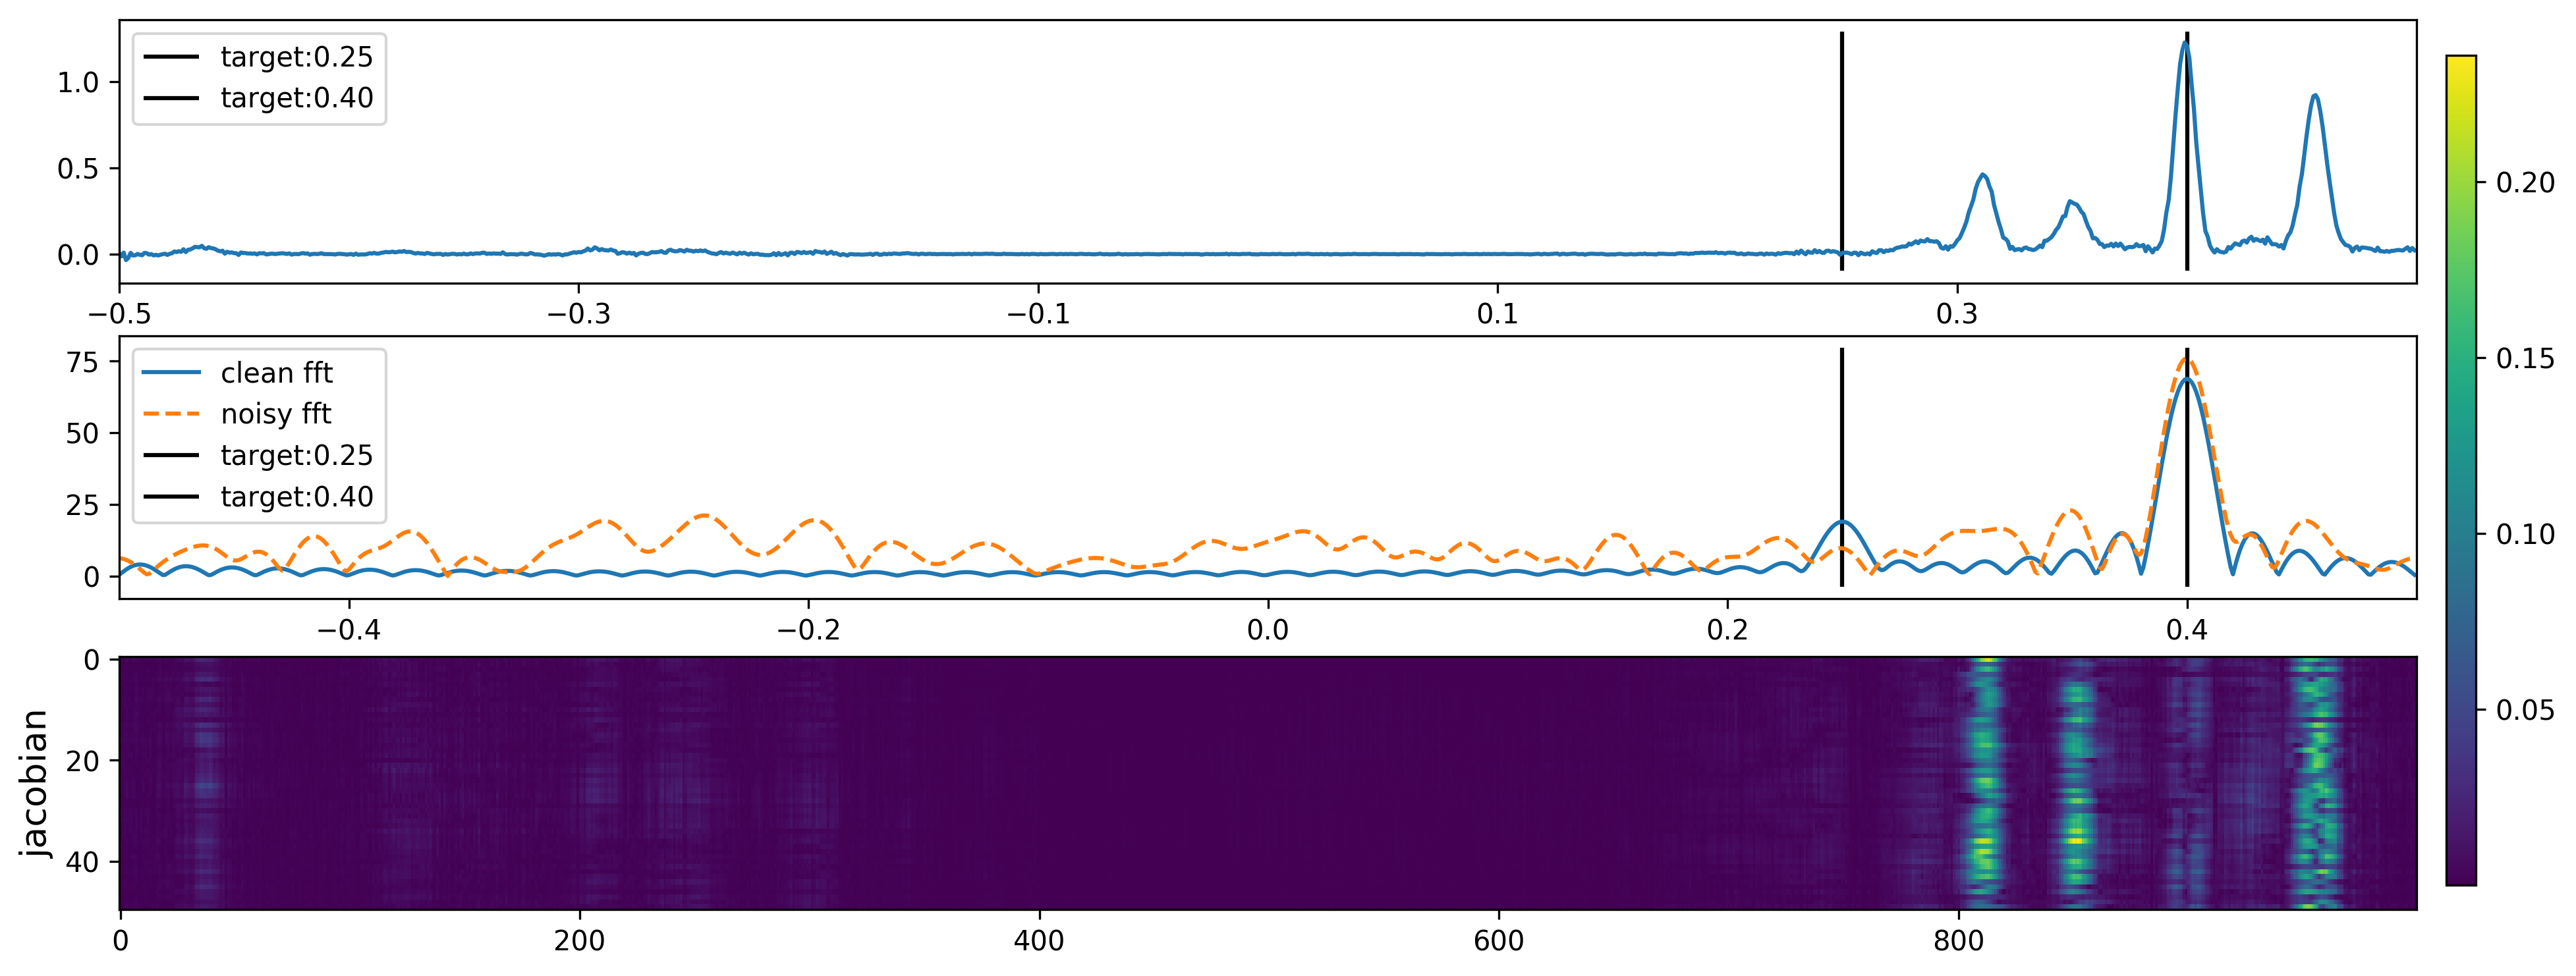

In [107]:
fig, ax = plt.subplots(3, 1, figsize=(15, 6), dpi=300)
xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)
ax[0].plot(xgrid, outputs[0])
ax[0].set_xticks(np.arange(-0.5, 0.5, 0.2))
ylim = ax[0].get_ylim()
for i in range(signal_fr.shape[0]):
    ax[0].vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
ax[0].legend()
ax[0].set_xlim(-0.5, 0.5)
ax[1].plot(xgrid, np.abs(clean_signal_fft),label='clean fft')
ax[1].plot(xgrid, np.abs(noisy_signal_fft),'--', label='noisy fft')
ax[1].set_xlim(-0.5, 0.5)
ylim = ax[1].get_ylim()
for i in range(signal_fr.shape[0]):
    ax[1].vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
ax[1].legend()
im = ax[2].imshow(np.abs(fft_filter))
ax[2].set_aspect(2.2)
ax[2].set_ylabel('jacobian', fontsize=13)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

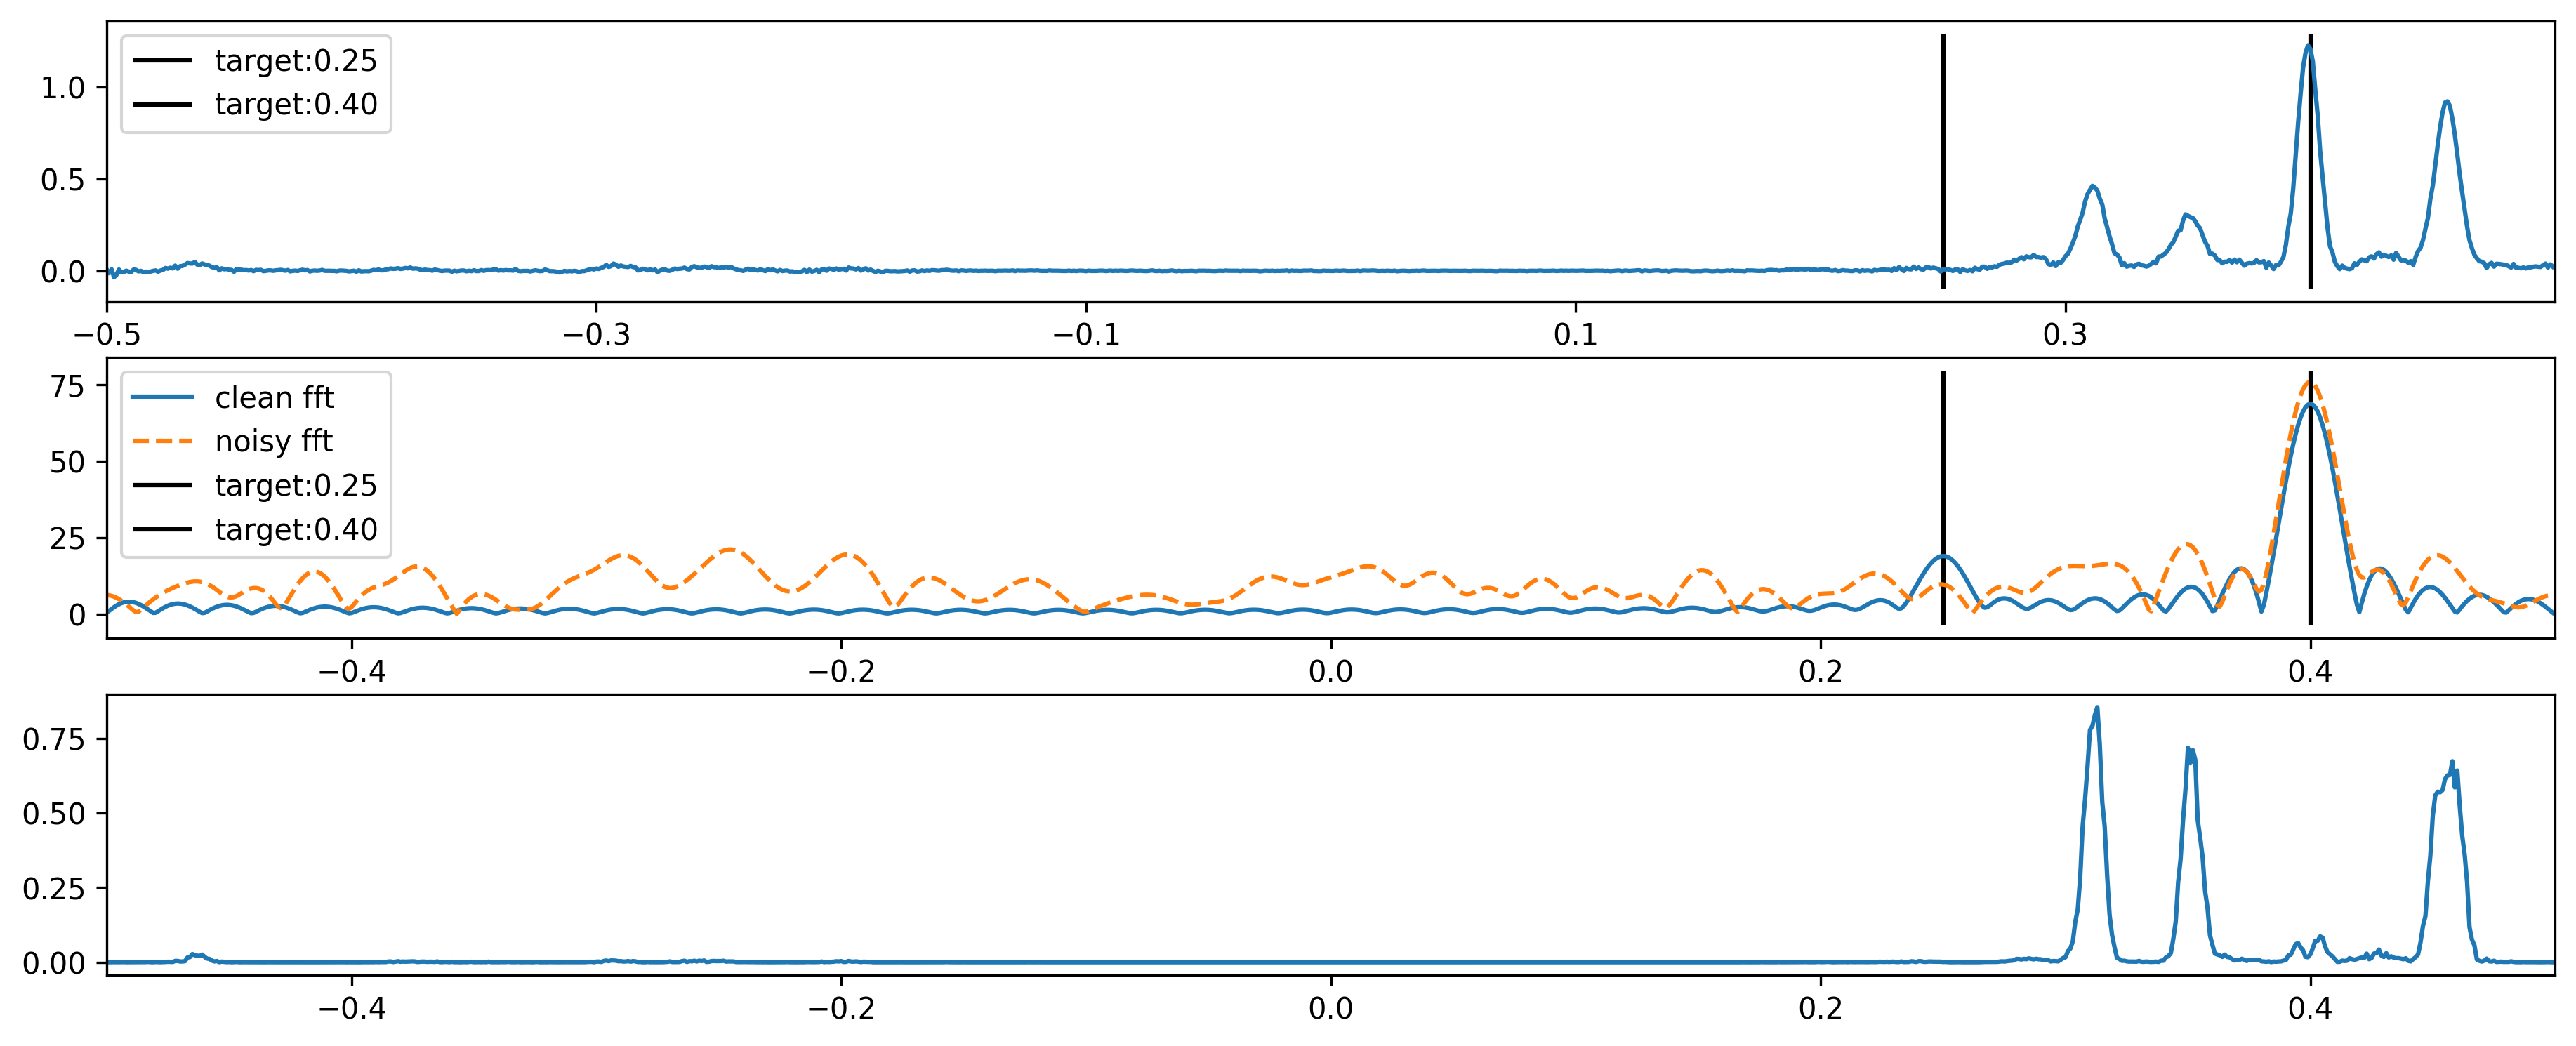

In [108]:
fig, ax = plt.subplots(3, 1, figsize=(15, 6),dpi=300)
xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)
ax[0].plot(xgrid, outputs[0])
ax[0].set_xticks(np.arange(-0.5, 0.5, 0.2))
ylim = ax[0].get_ylim()
for i in range(signal_fr.shape[0]):
    ax[0].vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
ax[0].legend()

ax[1].plot(xgrid, np.abs(clean_signal_fft),label='clean fft')
ax[1].plot(xgrid, np.abs(noisy_signal_fft),'--', label='noisy fft')
ylim = ax[1].get_ylim()
for i in range(signal_fr.shape[0]):
    ax[1].vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
ax[1].legend()
fft_filter_norm = fft_filter * np.conjugate(fft_filter)
fft_filter_norm = fft_filter_norm.T.sum(axis=1).real
ax[2].plot(xgrid, fft_filter_norm)
ax[0].set_xlim(-0.5, 0.5)
ax[1].set_xlim(-0.5, 0.5)
ax[2].set_xlim(-0.5, 0.5)

fig.subplots_adjust(right=0.9)
plt.show()

## Plot the corresponding row to time and frequency domain

In [109]:
indices = find_neariest_idx(signal_fr, xgrid)
target_filter = fft_filter.T[indices]

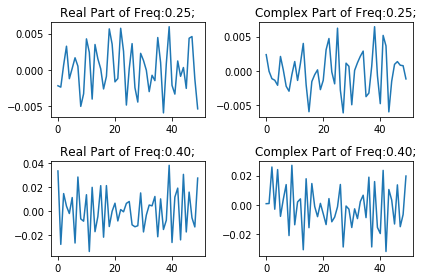

In [111]:
# time domain
fig, ax = plt.subplots(target_filter.shape[0], 2)
for idx, filt in enumerate(target_filter):
    if target_filter.shape[0] > 1:
        ax[idx, 0].plot(filt.real)
        ax[idx, 1].plot(filt.imag)
        ax[idx, 0].set_title('Real Part of Freq:{:4.2f};'.format(signal_fr[idx]))
        ax[idx, 1].set_title('Complex Part of Freq:{:4.2f};'.format(signal_fr[idx]))
    else:
        ax[0].plot(filt.real)
        ax[1].plot(filt.imag)
        ax[0].set_title('Real Part of Freq:{:4.2f};'.format(signal_fr[idx]))
        ax[1].set_title('Complex Part of Freq:{:4.2f};'.format(signal_fr[idx]))
plt.tight_layout()

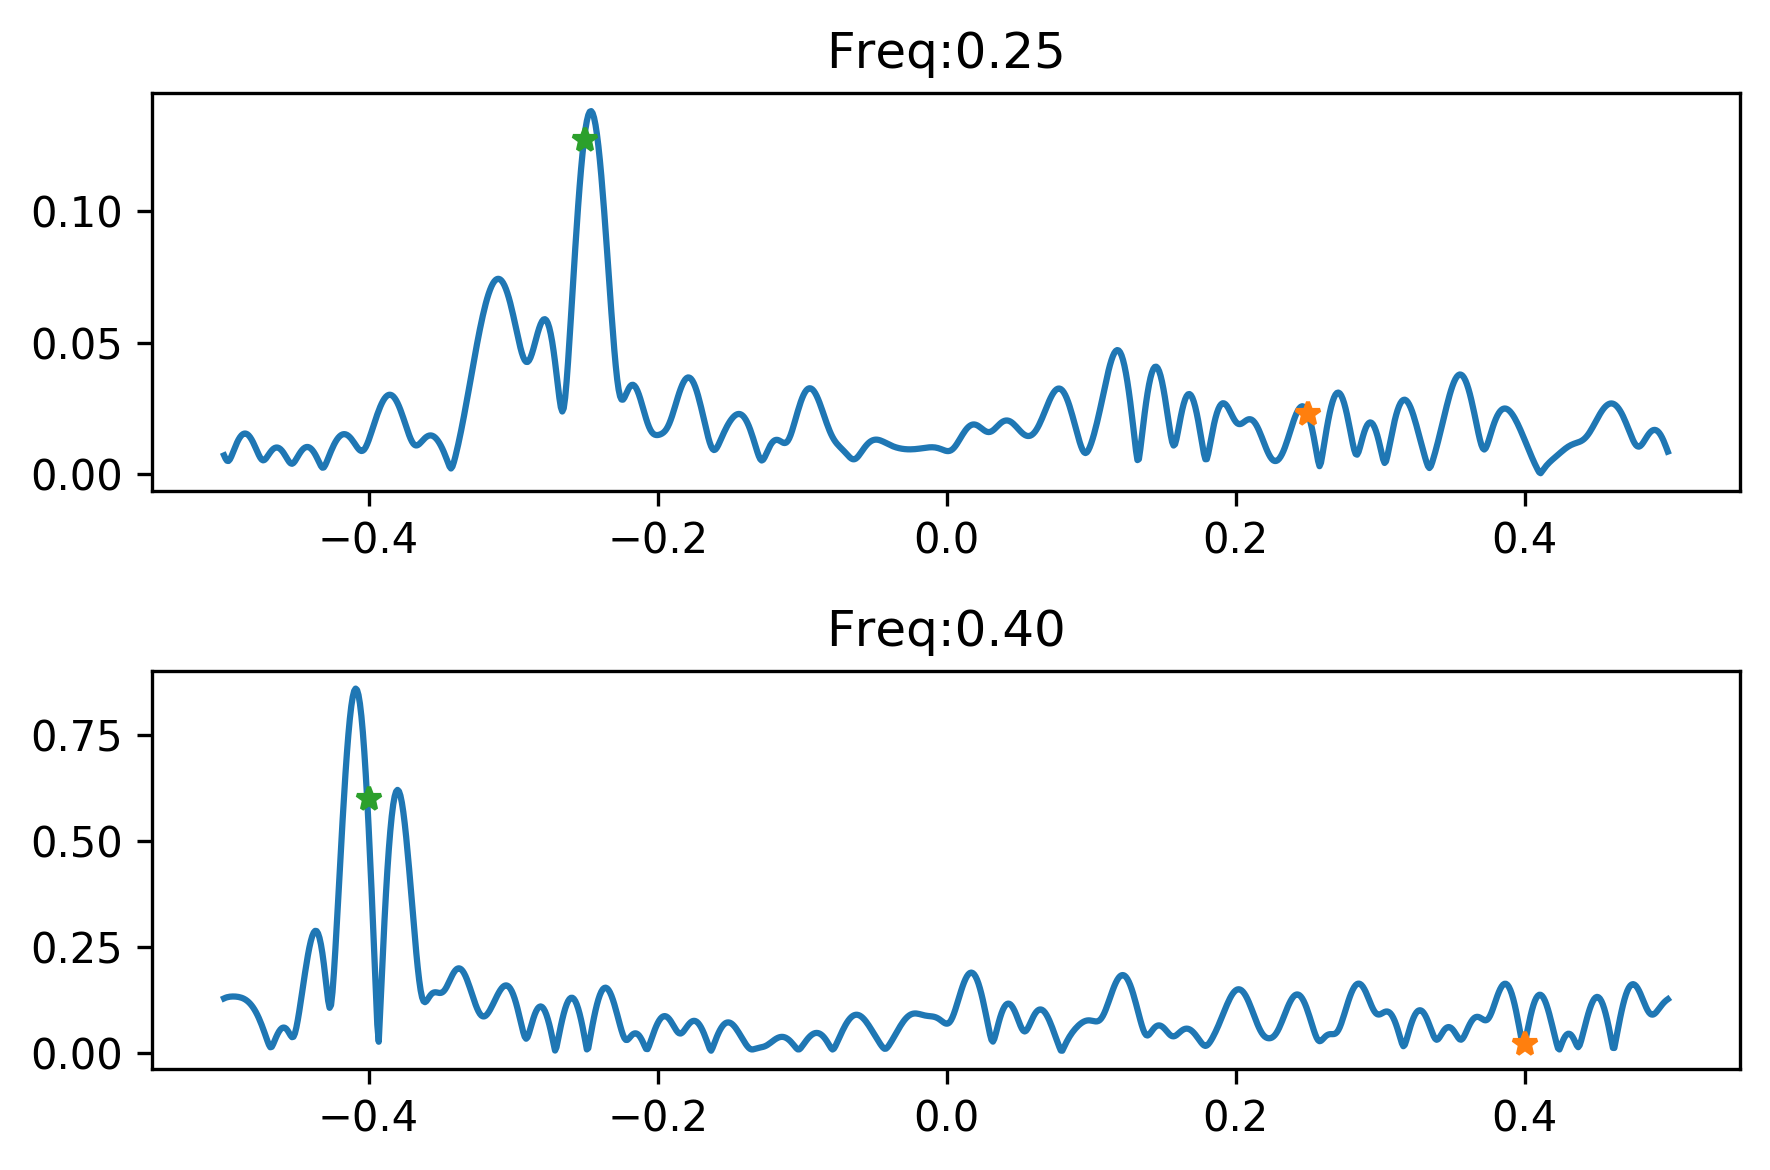

In [112]:
# fft domian of signals
fig, ax = plt.subplots(target_filter.shape[0], 1,  dpi=300)
for idx, filt in enumerate(target_filter):
    filt_fft = np.fft.fft(filt,n=1000)
    filt_fft = np.fft.fftshift(filt_fft)
    magnitude = np.abs(filt_fft)
    if target_filter.shape[0] > 1:
        ax[idx].plot(xgrid, magnitude)
        ax[idx].plot(signal_fr[idx], magnitude[indices[idx]], '*')
        ax[idx].plot(-signal_fr[idx], magnitude[999 - indices[idx]], '*')
        ax[idx].set_title('Freq:{:4.2f}'.format(signal_fr[idx]))
    else:
        ax.plot(xgrid, magnitude)
        ax.plot(signal_fr[idx], magnitude[indices[idx]], '*')
        ax.plot(-signal_fr[idx], magnitude[999-indices[idx]], '*')
        ax.set_title('Freq:{:4.2f}'.format(signal_fr[idx]))
plt.tight_layout()

In [107]:
# plot some other rows
# fft domian of signals
start=700
end=800
interval=1
file_name = 'jac_row_s_{}_e_{}_i_{}.pdf'.format(start, end, interval)
pdf = matplotlib.backends.backend_pdf.PdfPages("./plots/" + file_name)

for idx in range(start, end, interval):
    freq_label = xgrid[idx]
    filt_non = fft_filter.T[idx]
    fig, ax = jac_row_plot(idx, freq_label, filt_non, n=5)
    pdf.savefig(fig)
    plt.close()
pdf.close()
    

In [72]:
peaks_indices

array([34, 57])

## SVD on Jacobian matrices

In [110]:
fft_filter_svd = fft_filter.T
u,s, vh = np.linalg.svd(fft_filter_svd)

In [167]:
# hyper parameter setting
num_samples=10
signal_dim=50
min_sep=1.
snr_list=[1, 5, 10, 30, 50]
#fixed_freq = [0.1,0.15, 0.2, 0.25, 0.3, 0.35, 0.4] # set None for  random frequency
fixed_freq = [0.4]
num_freq=len(fixed_freq)

In [169]:
results = {}
for snr in snr_list:
    results[snr]={}
    jacobian_realization, jacobian_realization_clean = jac, jac_clean = compute_jacobian_realization(
    fr_module,
    num_samples, 
    signal_dim, 
    num_freq, 
    min_sep, 
    fixed_freq, 
    snr)
    eigenvals, left_eigenvecs, right_eigenvecs, eff_dims = get_svd(jacobian_realization)
    eigenvals_cl, left_eigenvecs_cl, right_eigenvecs_cl, eff_dims_cl = get_svd(jacobian_realization_clean)
    results[snr]['noisy'] = (eigenvals, left_eigenvecs, right_eigenvecs, eff_dims)
    results[snr]['clean'] = (eigenvals_cl, left_eigenvecs_cl, right_eigenvecs_cl, eff_dims_cl)
    

21.528908
6.807762
5.377738
12.112706
17.625813
25.444628
15.904852
22.182945
51.033993
18.962143
0.5816074
0.7003428
1.5017883
1.7305592
0.75275147
1.6061674
0.9079394
1.6974151
0.89129925
0.76421785
11.67301
6.906682
0.66432595
2.1388183
9.578131
0.87624454
1.0709594
0.53171647
0.7720471
3.059168
4.197821
0.6636816
0.7415234
10.2509985
12.6744995
0.5903583
0.8581566
0.7252957
0.872051
0.91340303
0.7912451
1.0822194
3.9773457
2.510104
0.8179411
1.3992044
10.896362
10.555775
0.6265071
5.382266
0.760029
1.3317536
3.1649094
2.6557057
0.7489433
13.882864
8.886099
4.8005958
0.7251229
0.77148163
4.0704184
9.742467
0.93724483
1.3346273
14.783833
1.3364769
1.1145562
1.0534719
6.4901967
1.4514989
3.5745568
1.0187508
0.68135524
0.7089574
4.801201
1.3551083
1.0443718
0.90160406
1.6879021
1.999212
0.98023224
1.0570426
7.9922423
0.99052966
0.6386411
0.97372127
0.8686423
0.9925729
0.7939059
0.6585425
1.619065
0.7641306
8.495052
0.6706743
0.67510736
0.94525397
0.9084137
0.84289354
0.7208719
0.718726

In [170]:
# cached 
import pickle
with open('saved_results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [10]:
# load
import pickle
with open('saved_results.pkl', 'rb') as f:
    results = pickle.load(f)

NameError: name 'xgrid' is not defined

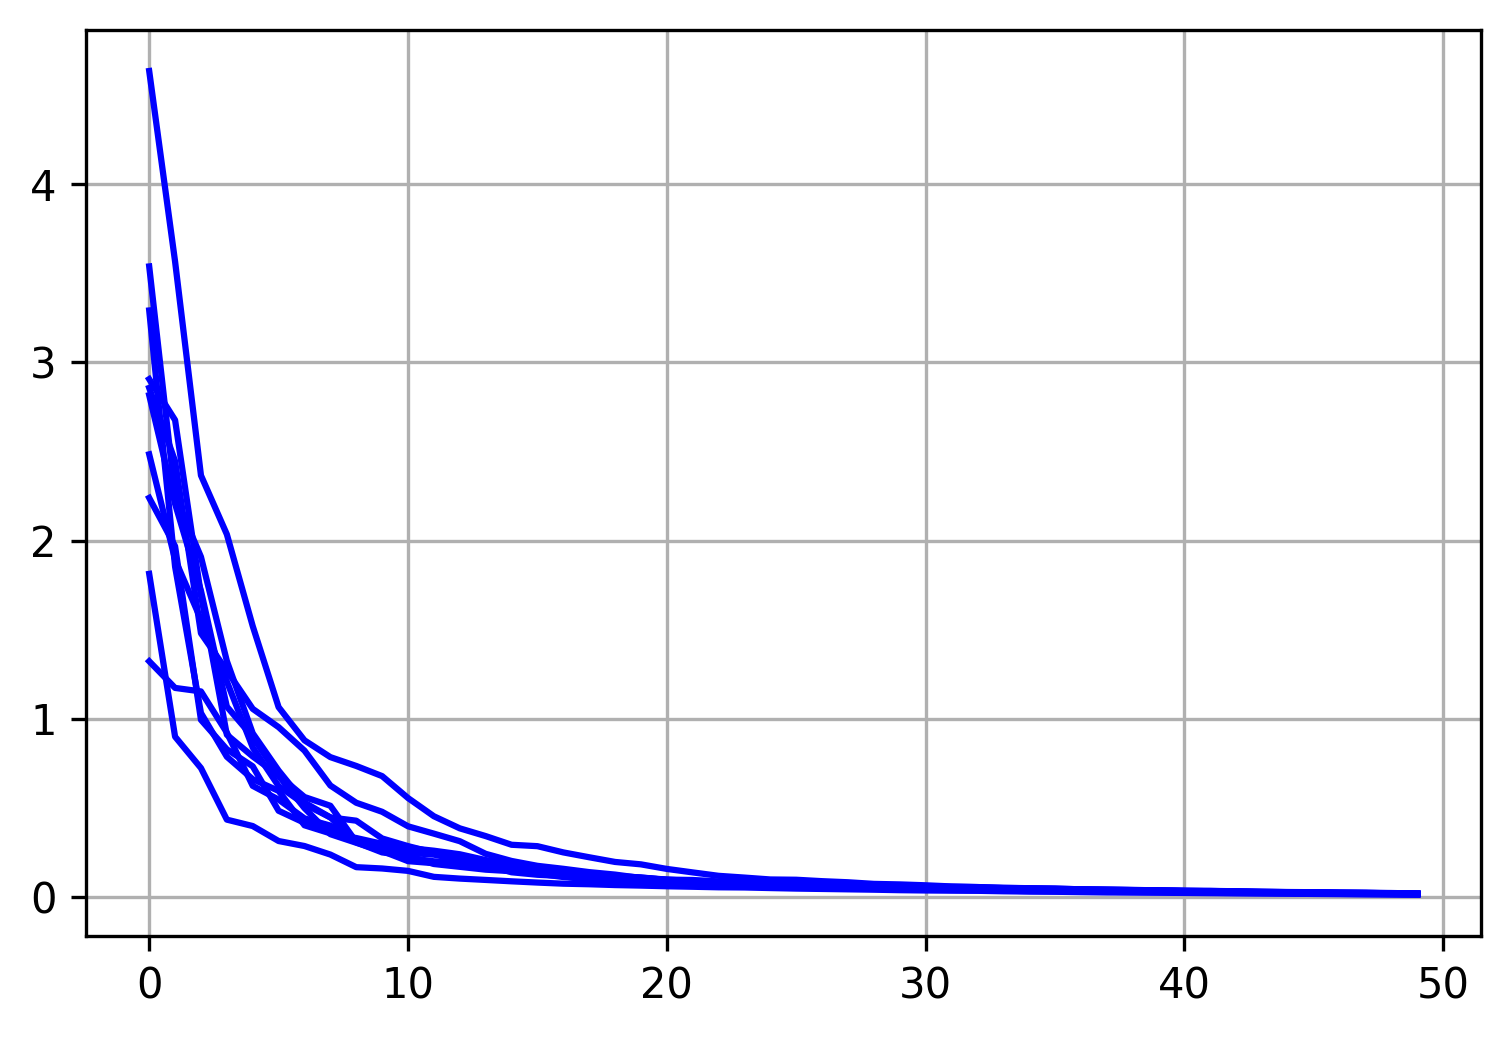

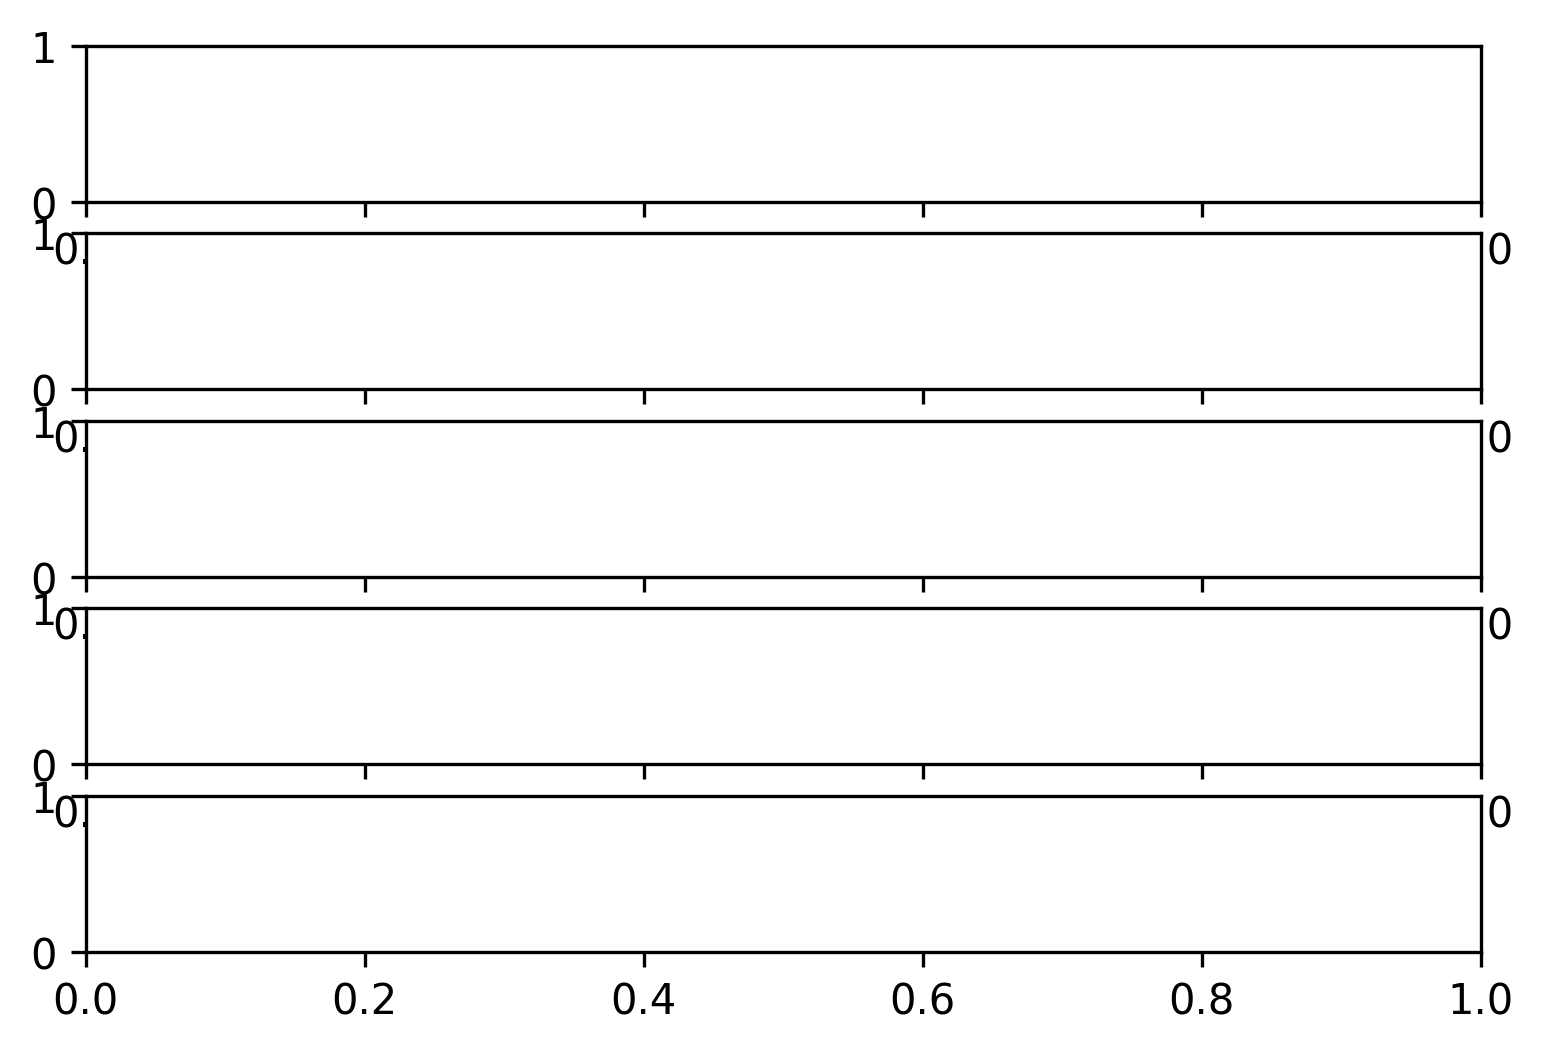

In [171]:
n=5
for snr in snr_list:
    pdf1 = matplotlib.backends.backend_pdf.PdfPages("./plots/noise_{}.pdf".format(snr))
    pdf2 = matplotlib.backends.backend_pdf.PdfPages("./plots/clean_{}.pdf".format(snr))
    eigenvals, left_eigenvecs, right_eigenvecs, eff_dims = results[snr]['noisy']
    fig1 = plot_eigenval(eigenvals)
    fig2 = plot_eigenvec(n, left_eigenvecs[0])
    fig3 = plot_eigenvec(n, left_eigenvecs[0], reverse=True)
    
    pdf1.savefig(fig1)
    pdf1.savefig(fig2)
    pdf1.savefig(fig3)
    pdf1.close()
    plt.close(fig1)
    plt.close(fig2)
    plt.close(fig3)
    eigenvals_cl, left_eigenvecs_cl, right_eigenvecs_cl, eff_dims_cl = results[snr]['clean']
    fig1 = plot_eigenval(eigenvals_cl)
    fig2 = plot_eigenvec(n, left_eigenvecs_cl[0])
    fig3 = plot_eigenvec(n, left_eigenvecs_cl[0], reverse=True)
    pdf2.savefig(fig1)
    pdf2.savefig(fig2)
    pdf2.savefig(fig3)
    pdf2.close()
    plt.close(fig1)
    plt.close(fig2)
    plt.close(fig3)

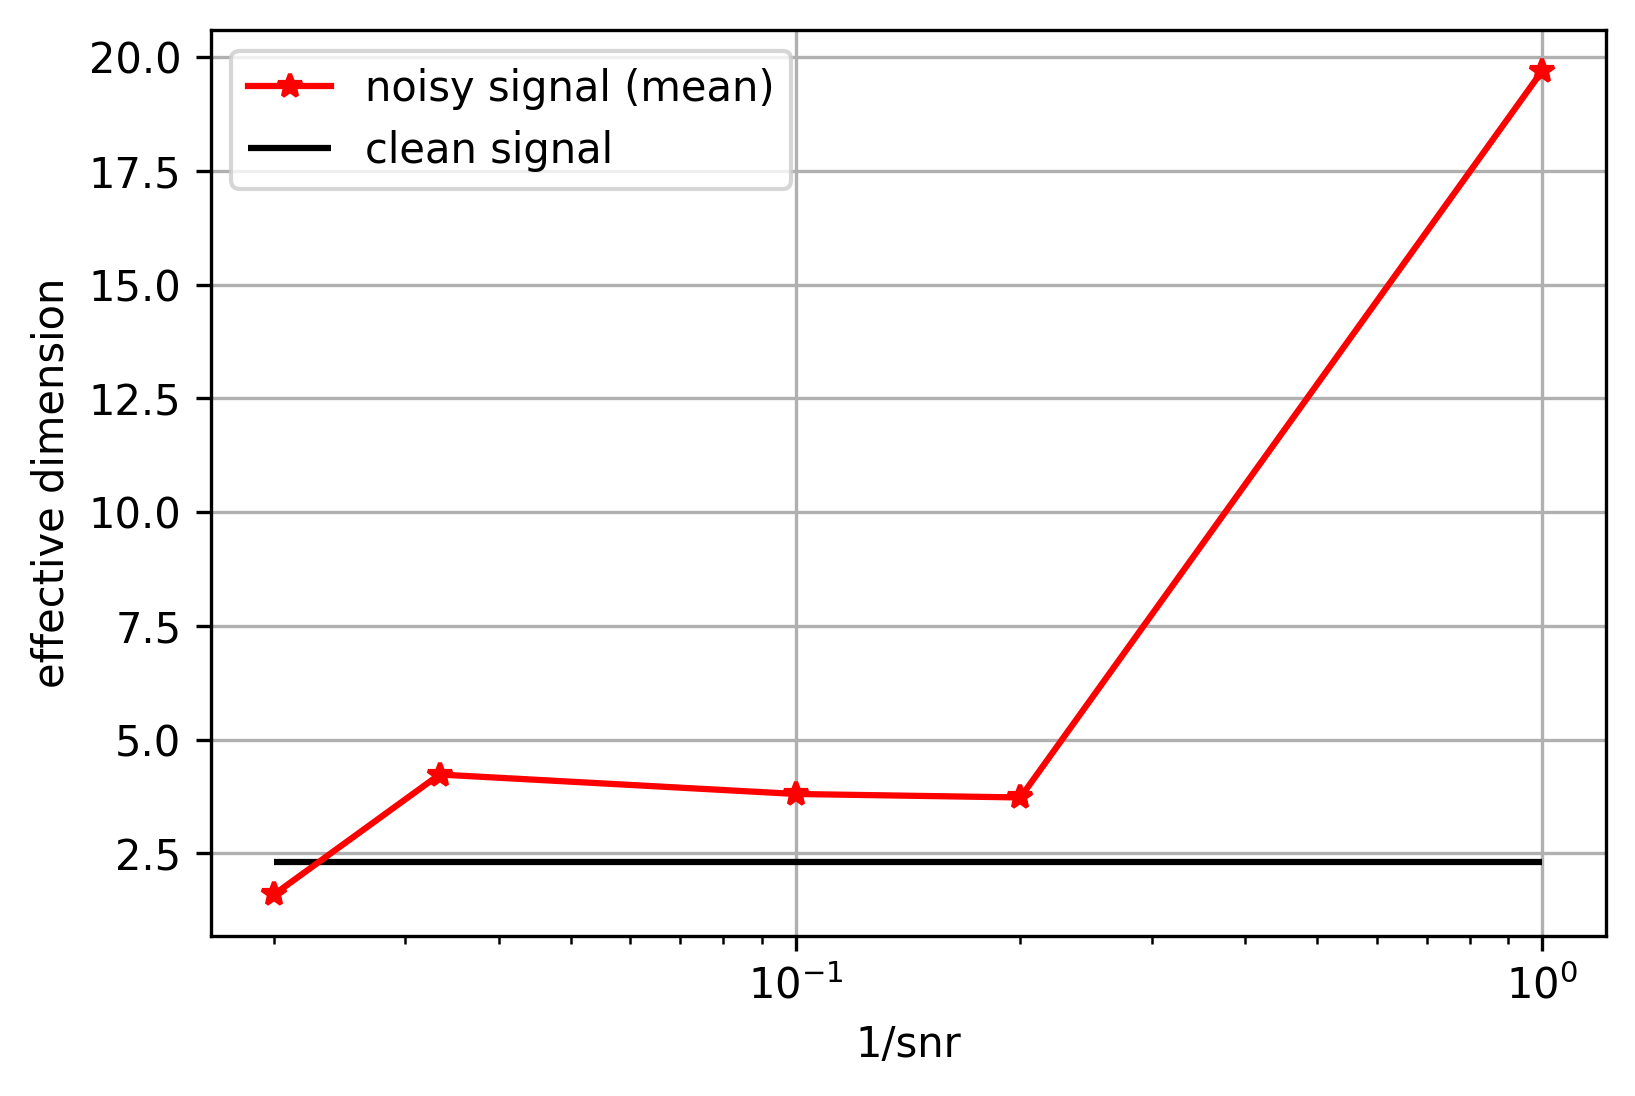

In [172]:
#  effective dimensions
n=5
mean_eff_dims = []
mean_eff_dims_cl = []
plt.figure(dpi=300)
data_to_plot = []
for snr in snr_list:
    eigenvals, left_eigenvecs, right_eigenvecs, eff_dims = results[snr]['noisy']
    eigenvals_cl, left_eigenvecs_cl, right_eigenvecs_cl, eff_dims_cl = results[snr]['clean']
    mean_eff_dims.append(np.mean(eff_dims))
    mean_eff_dims_cl.append(np.mean(eff_dims_cl))
    data_to_plot.append(eff_dims)
data_to_plot = np.stack(data_to_plot).T
#for i in range(data_to_plot.shape[0]):
#    plt.plot(snr_list, data_to_plot[i], color='blue', lw=1)
x = 1/np.array(snr_list)
plt.semilogx(x, mean_eff_dims,'-*', color='red', label='noisy signal (mean)')
plt.hlines(np.mean(mean_eff_dims_cl),xmin=x.min(), xmax=x.max(),label='clean signal')
plt.grid()
plt.xlabel('1/snr')
plt.ylabel('effective dimension')
plt.legend()

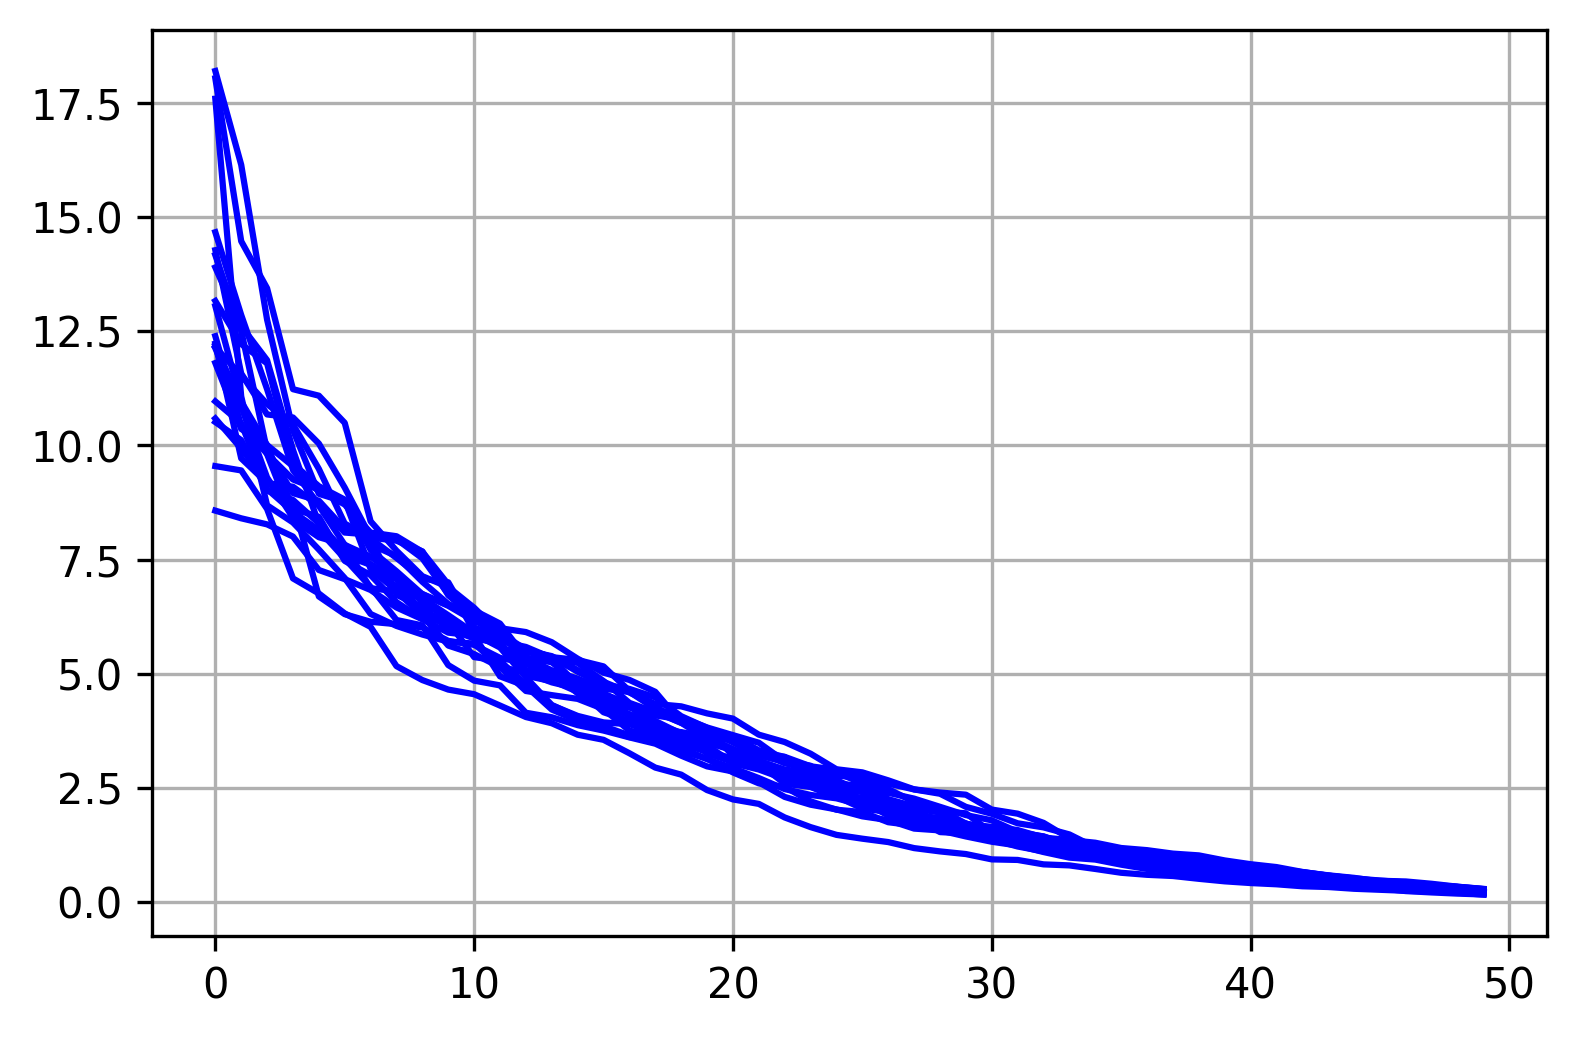

In [15]:

fig = plot_eigenval(eigenvals)

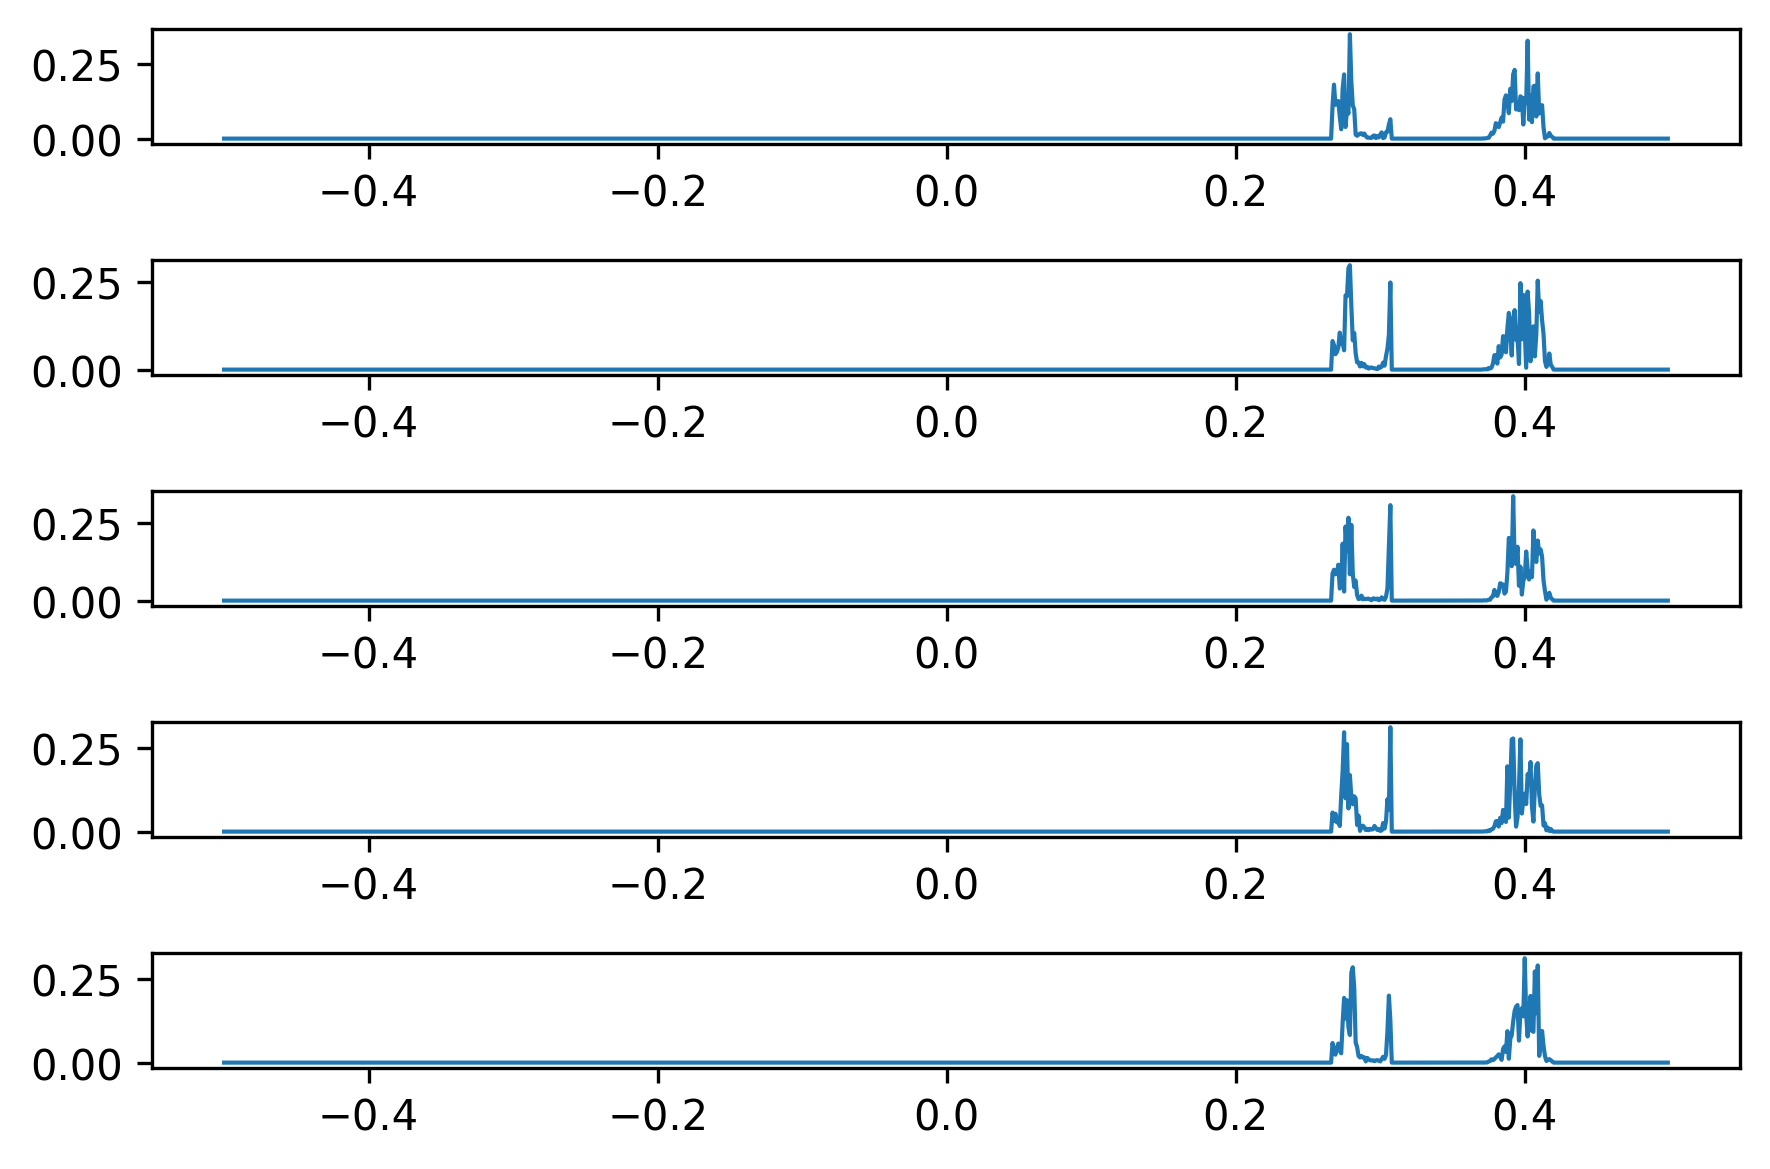

In [293]:
plot_eigenvec(n, u, reverse=True)

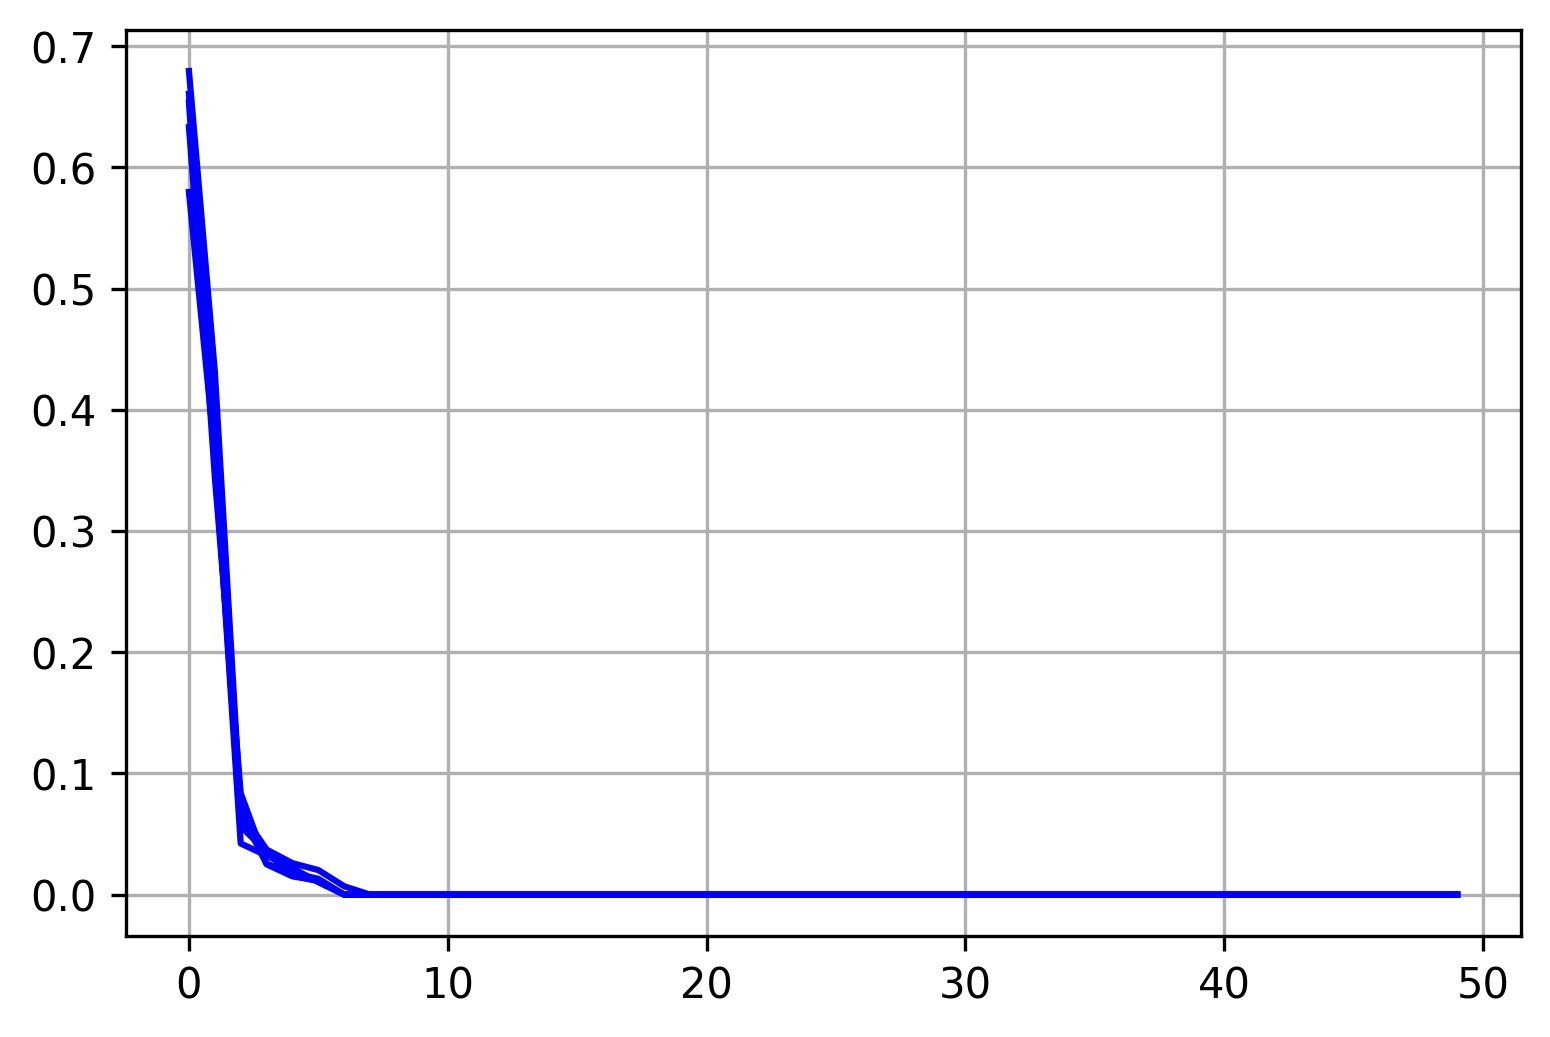

In [294]:
plot_eigenval(eigenvals_cl)

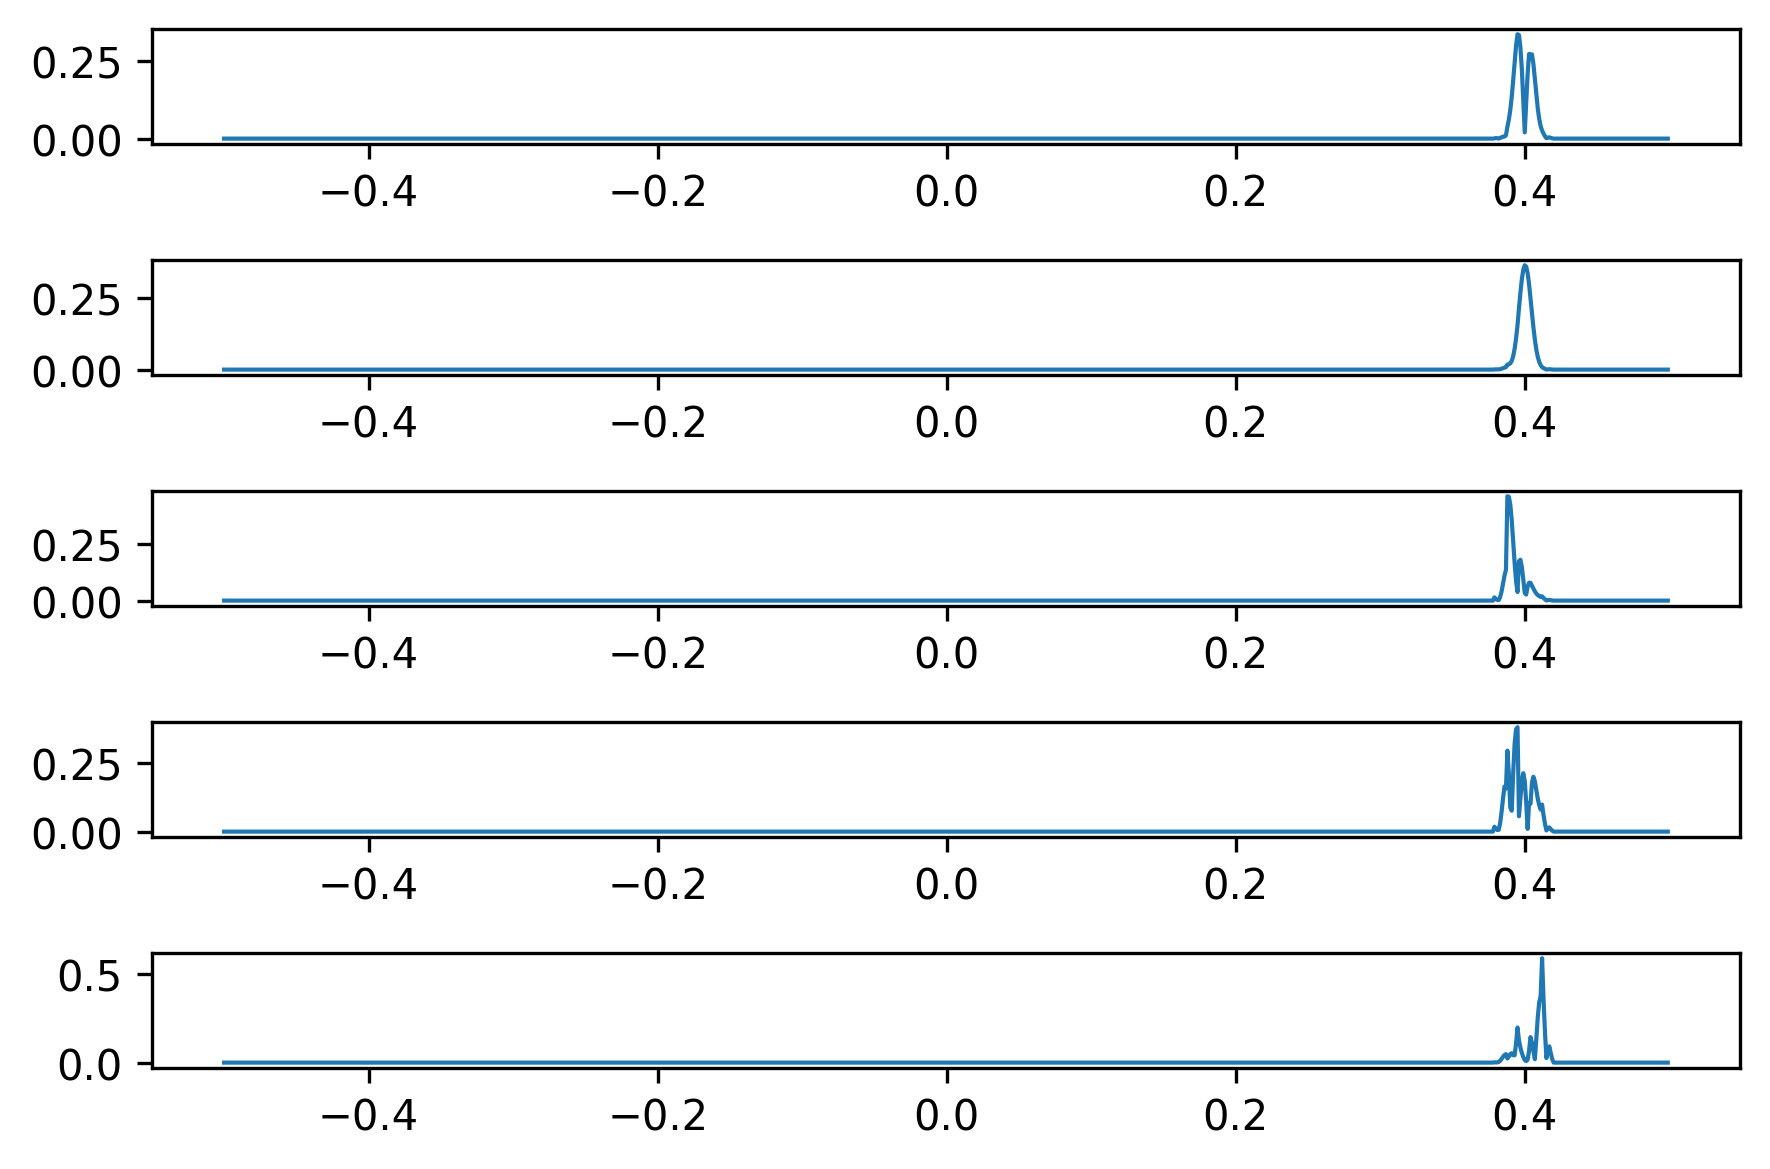

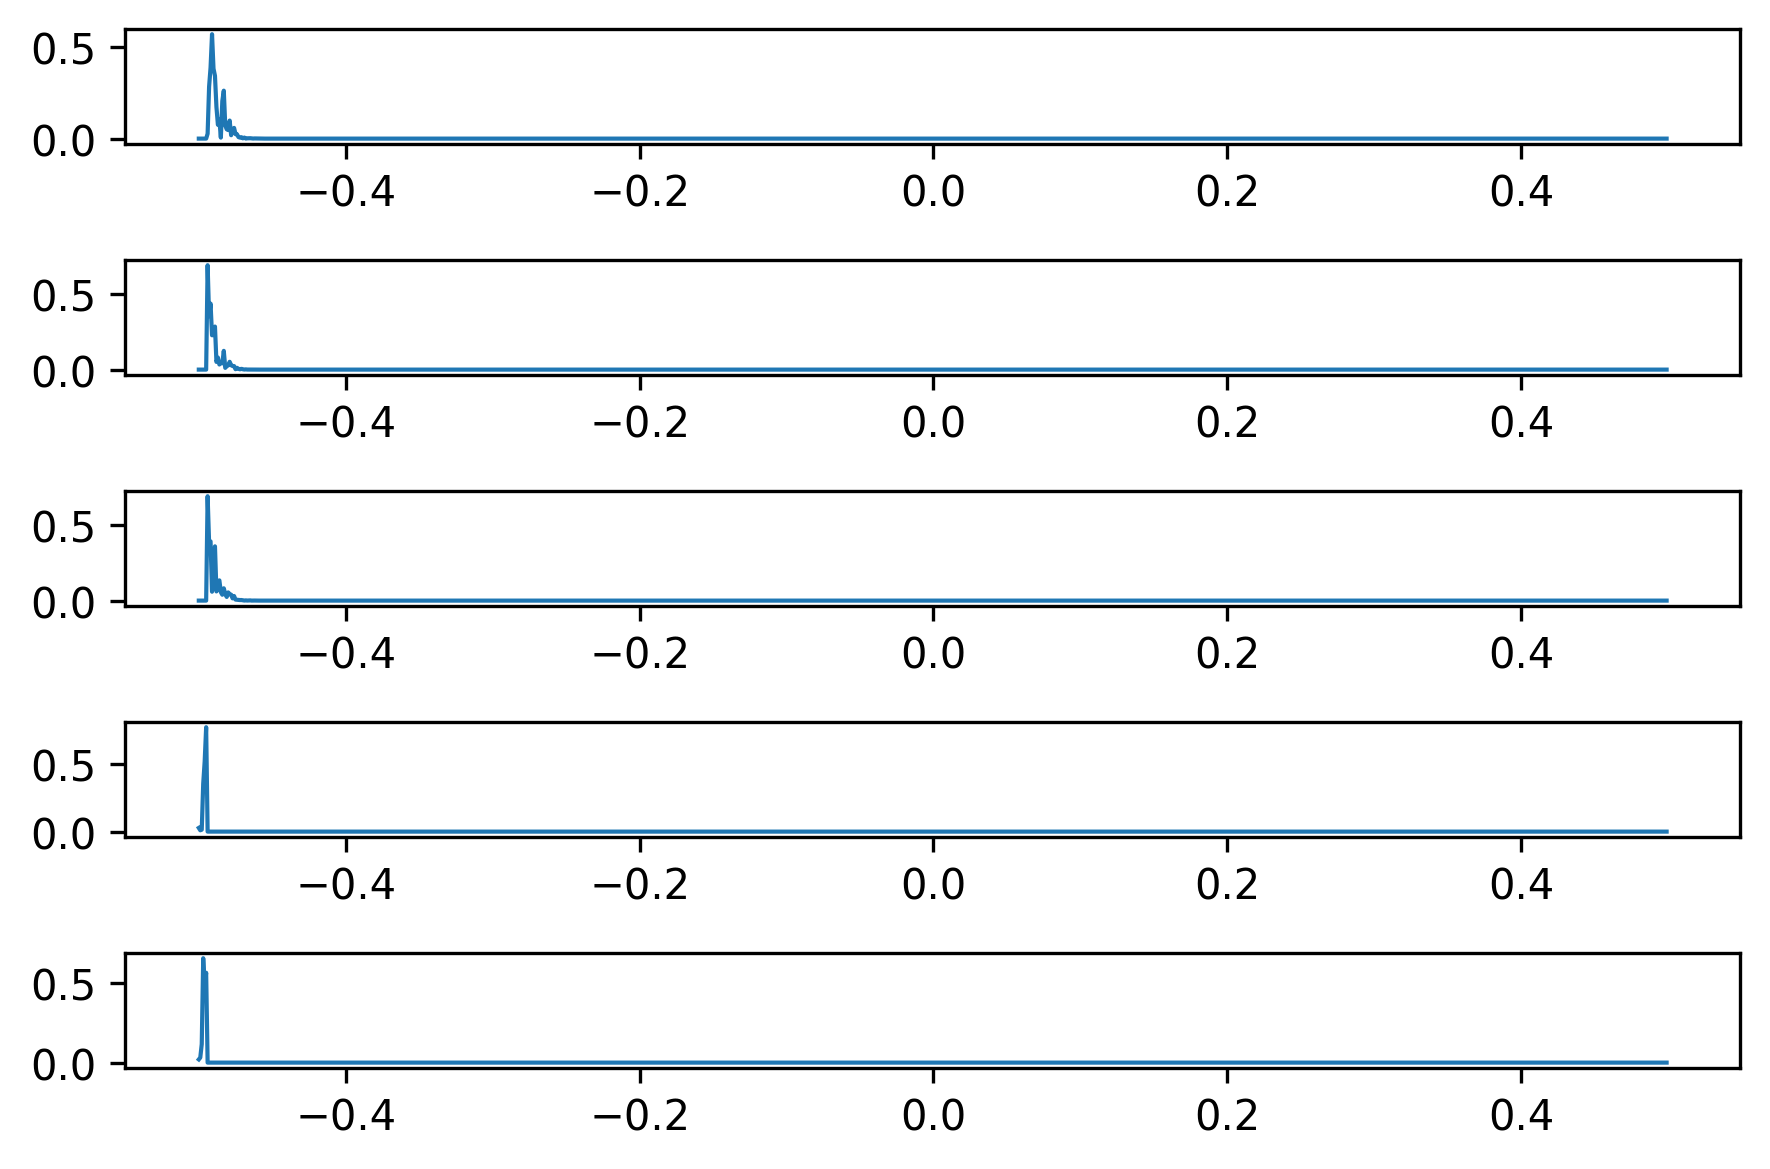

In [295]:
u = left_eigenvecs_cl[0]
plot_eigenvec(5, u)
plot_eigenvec(5,u,reverse=True)

## PCA

In [95]:
# hyper parameter setting
num_samples=20
signal_dim=50
min_sep=1.
snr_list=[1, 5, 10, 30, 50]
#fixed_freq = [0.1,0.15, 0.2, 0.25, 0.3, 0.35, 0.4] # set None for  random frequency
fixed_freq = [0.3, 0.4]
num_freq=len(fixed_freq)
snr=1
jac, jac_clean = compute_jacobian_realization(
    fr_module,
    num_samples, 
    signal_dim, 
    num_freq, 
    min_sep, 
    fixed_freq, 
    snr)
jac = np.stack(jac)

In [159]:
snr=1


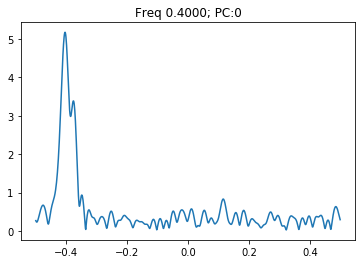

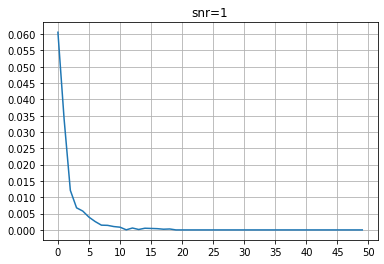

In [96]:
fig, ax, s, u = pca_plots(jac, fixed_freq, num_samples, signal_dim, idx_comp=0, fixed_freq_idx=1)
plt.figure()
plt.plot(np.abs(s))
plt.title('snr={}'.format(snr))
plt.locator_params(nbins=15)
plt.grid()

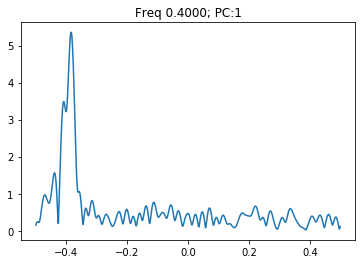

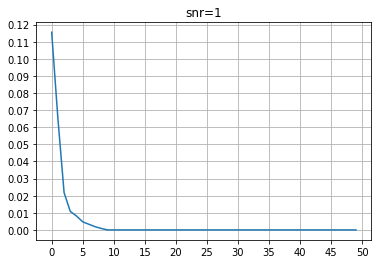

In [145]:
resolution=1000
fig, ax, s, u = pca_plots(jac, fixed_freq,num_samples, signal_dim,idx_comp=1
                          , fixed_freq_idx=0, resolution=1000)
plt.figure()
plt.plot(np.abs(s))
plt.title('snr=1')
plt.locator_params(nbins=15)
plt.grid()

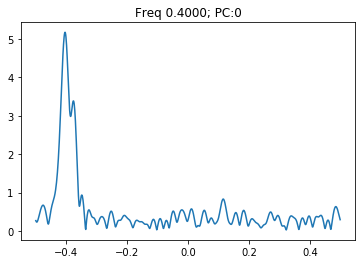

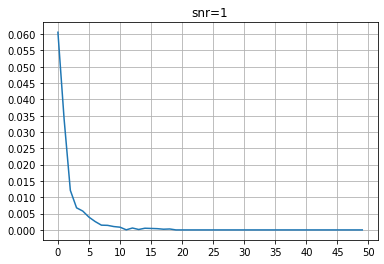

In [98]:
arbitary_row=900
fig, ax, s, u = pca_plots(jac, fixed_freq,num_samples, 
          signal_dim, idx_comp=0, fixed_freq_idx=0, arbitary_row=arbitary_row, resolution=1000)
plt.figure()
plt.plot(np.abs(s))
plt.title('snr=1')
plt.locator_params(nbins=15)
plt.grid()

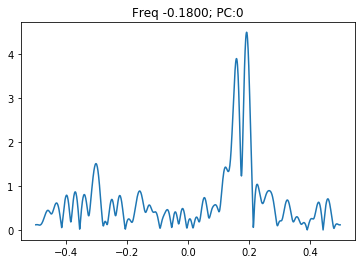

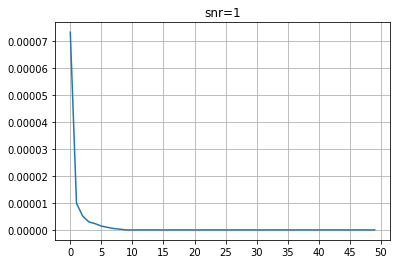

In [166]:
arbitary_row=320
fig, ax, s, u = pca_plots(jac, fixed_freq,num_samples, 
          signal_dim, idx_comp=0, 
          fixed_freq_idx=0, 
          arbitary_row=arbitary_row,
         resolution=resolution)
plt.figure()
plt.plot(np.abs(s))
plt.title('snr={}'.format(snr))
plt.locator_params(nbins=15)
plt.grid()

In [35]:
eigenvalues = []
for row_idx in range(0, 999, 1):
    _, _, s, u = pca_plots(jac, fixed_freq, num_samples, signal_dim, idx_comp=0, fixed_freq_idx=1,arbitary_row=row_idx)
    eigenvalues.append(s)
    plt.close()
eigenvalues  = np.stack(eigenvalues)

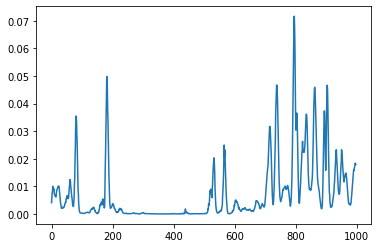

In [36]:
plt.figure()
plt.plot(np.abs(eigenvalues.T[0]))

# Output figures into PDF

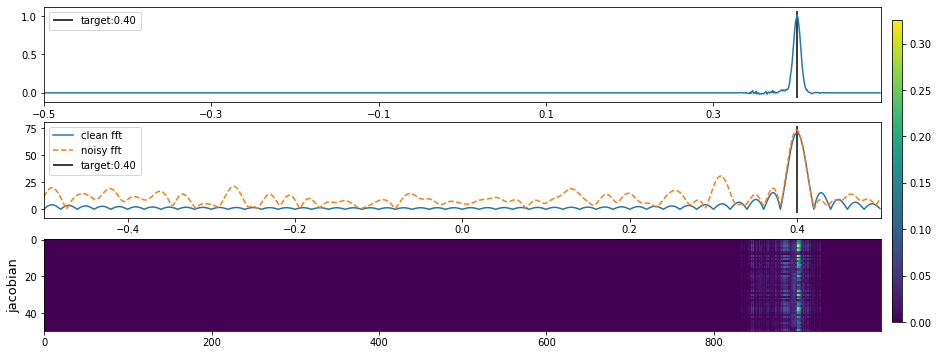

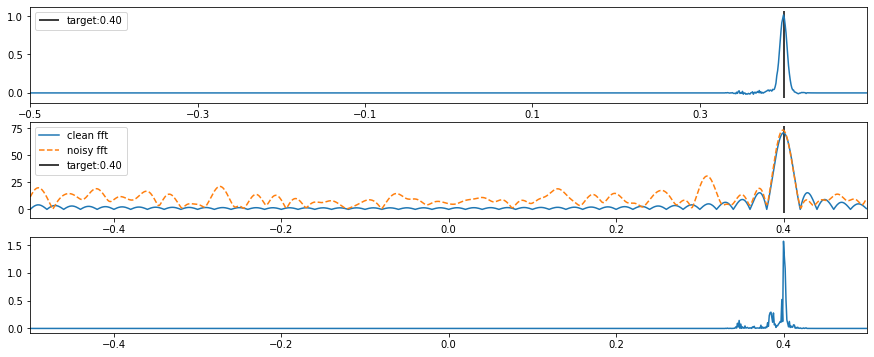

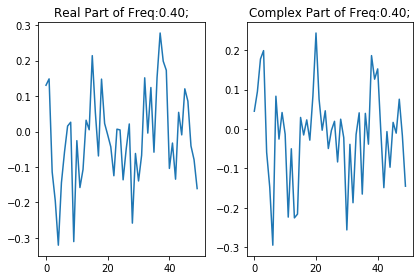

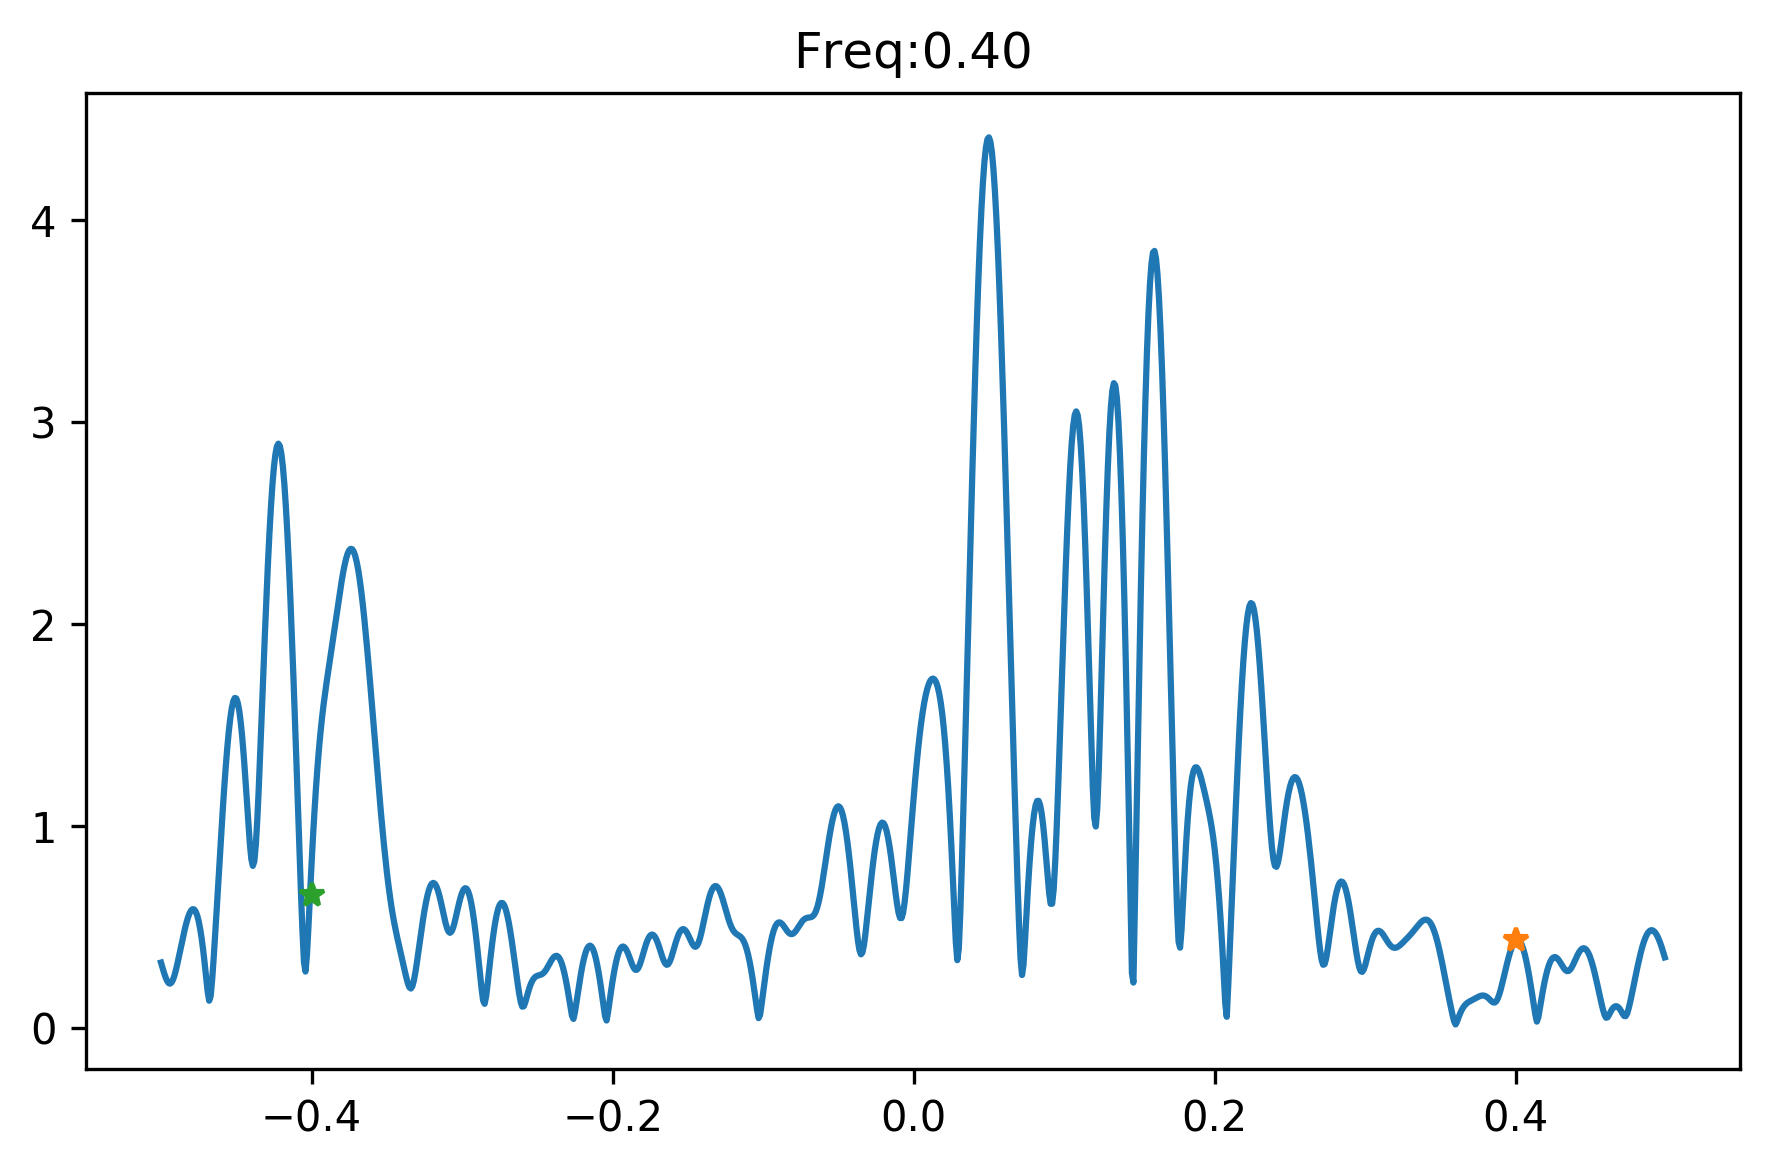

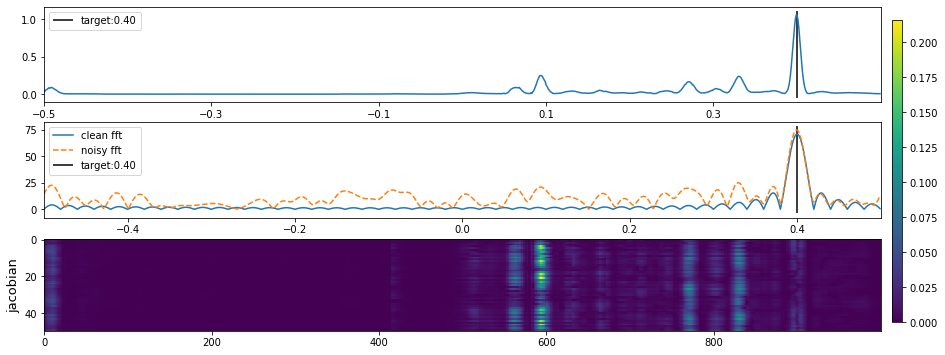

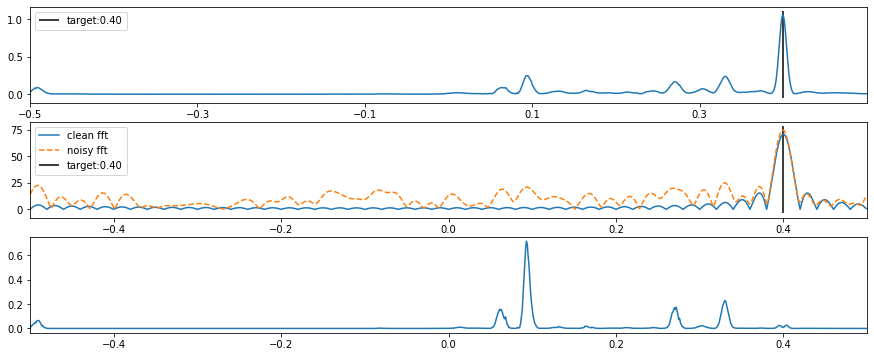

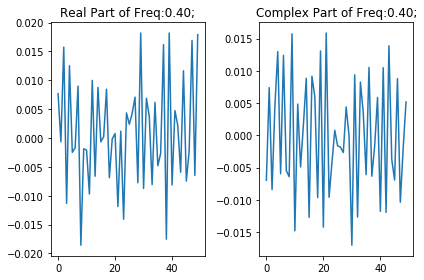

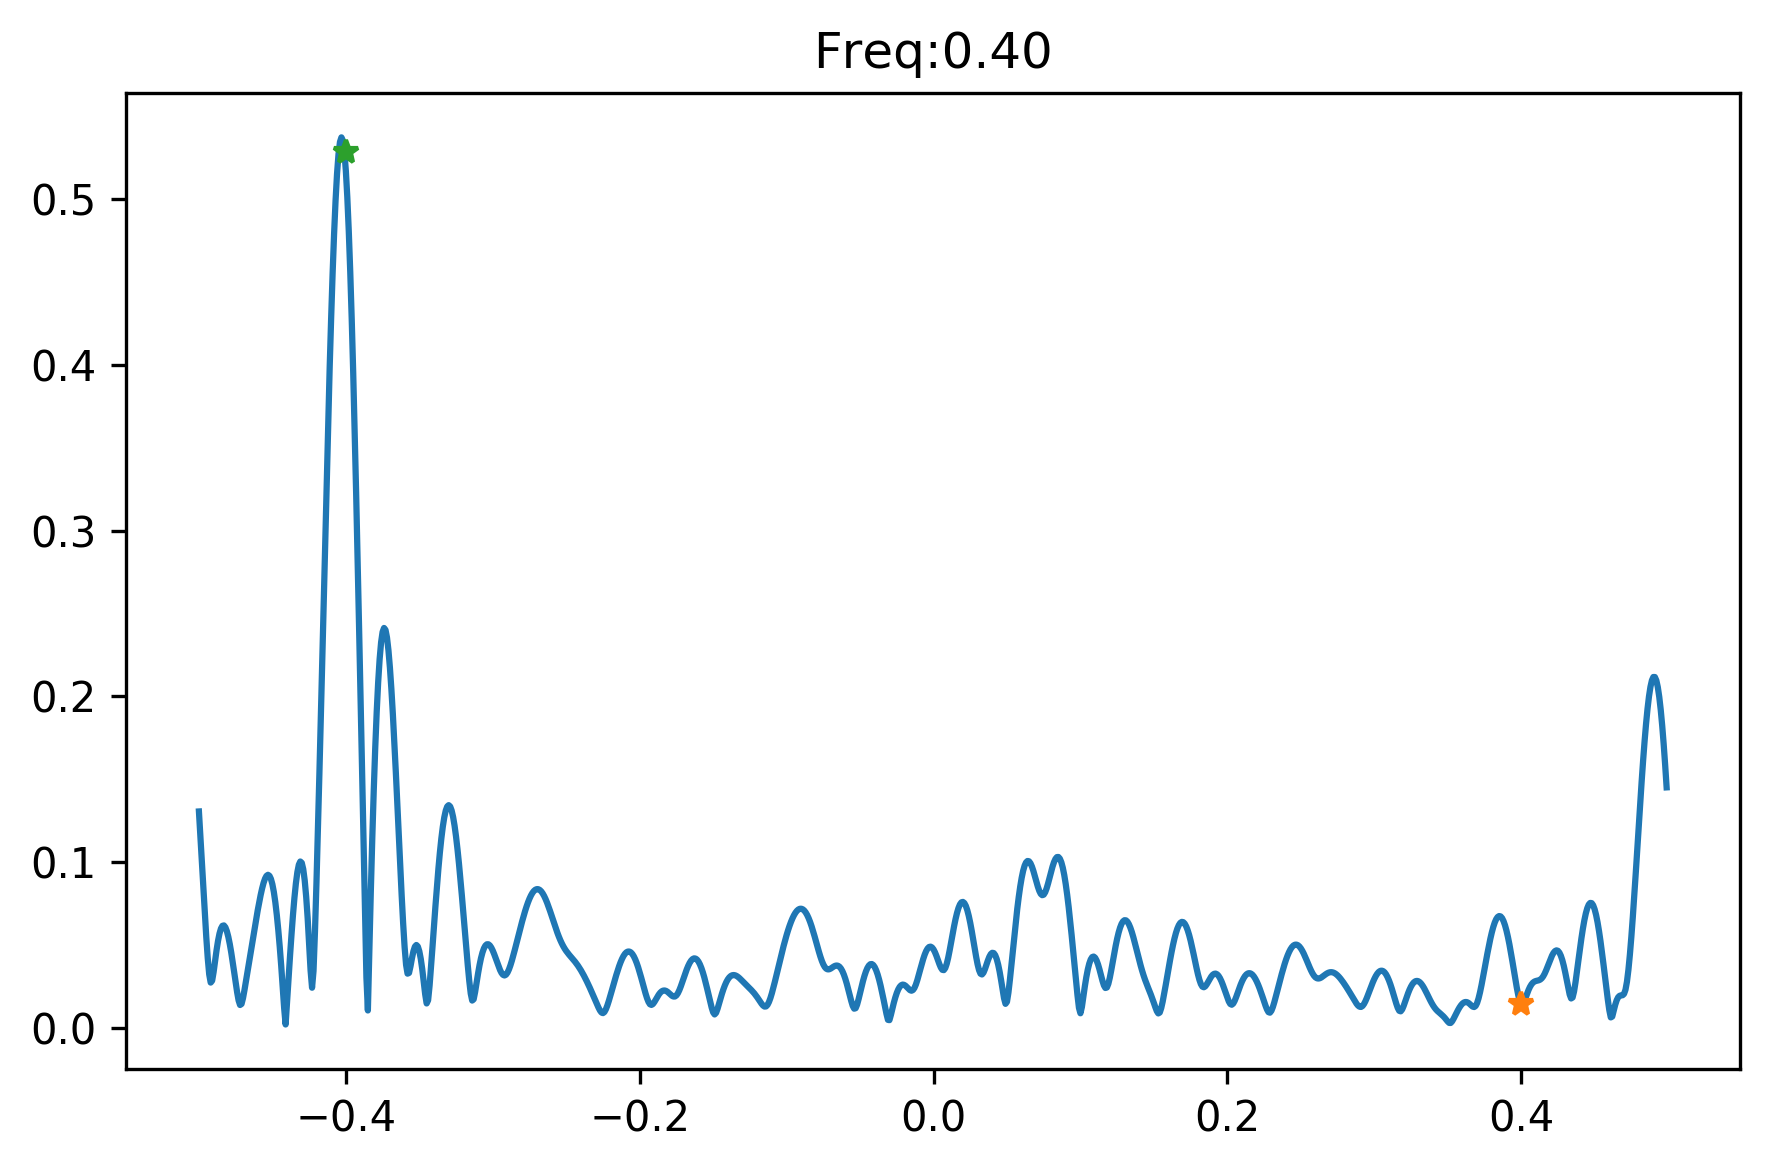

KeyboardInterrupt: 

In [113]:
# hyper parameter setting
num_samples=5
signal_dim=50
min_sep=1.
snr=30
fixed_freq = [0.4] # set None for  random frequency
num_freq=len(fixed_freq)
snr=1
generate_report_plots(num_samples=num_samples,
                      signal_dim=signal_dim,
                      min_sep=min_sep,
                      snr=snr,
                      fixed_freq=fixed_freq,
                      save=True)